In [1]:
import os
import tempfile
import pickle, sys
import pathlib
import numpy as np
from scipy.signal import stft
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

# Load data

In [2]:
PKLS_DIR = pathlib.Path(r"C:\Users\emmam\OneDrive\Dokumente\ETH\BT\code\small_test_set")

pkl_files = sorted(PKLS_DIR.glob("*.pkl"))
if not pkl_files:
    print(f"[ERROR] No *.pkl in {PKLS_DIR}")
    sys.exit(2)

In [ ]:
data_rows = []

for pkl_path in pkl_files:
    with pkl_path.open("rb") as fh:
        rows = pickle.load(fh)

        for i, row in enumerate(rows):
            data_rows.append(row)

### DELETE THIS BEFORE RUNNING ON ACTUAL DATA. ONLY FOR TESTING. During development we only consider a small subset. The following code lets you check the total duration of the selected sample rows.

In [ ]:
# def get_duration_ms(row):
#     sr = row["sampling_rate"]

#     duration_samples = row["duration_samples"]
#     duration_ms = (duration_samples / sr) * 1000.0
#     return duration_ms

In [ ]:
# duration_ms = 0
# for row in data_rows:
#     duration_ms += get_duration_ms(row)

# print(duration_ms)

315621.99762996694


# Reconstruct audio and neural spike data

In [4]:
def compute_stft(
    audio: np.ndarray,
    sampling_rate: float,
    win_ms: int,
    hop_ms: int,
):
    audio = np.asarray(audio)
    win_samples = int(round(sampling_rate * (win_ms / 1000.0)))
    hop_samples = int(round(sampling_rate * (hop_ms / 1000.0)))

    nperseg = min(win_samples, len(audio))
    noverlap = nperseg - hop_samples # the stft function wants the number of overlapping samples per window rather than the hop size

    f, t, Z = stft(
        audio,
        fs=sampling_rate,
        nperseg=nperseg,
        noverlap=noverlap,
        boundary=None,
        padded=False,
    )

    S = np.abs(Z).astype(np.float32) # S[f,t] := the strength of frequency bin f at time frame t
    frame_centers_sample = (t * sampling_rate).astype(int) # frame_centers_sample[t] := center of the t'th STFT window given as sample index in the original audio

    return {
        "freqs_hz": f,
        "frame_centers_sample": frame_centers_sample,
        "S": S,
        "win_ms": win_ms,
        "hop_ms": hop_ms,
    }

In [5]:
rows_by_file = defaultdict(list)
for r in data_rows:
    rows_by_file[r["source_file"]].append(r)

reconstructed = {}

for file_id, rows in rows_by_file.items():
    rows = sorted(rows, key=lambda r: r["onset_sample"])

    audio_parts = []
    end = 0

    spike_events = {
        "time": [],
        "neuron_ksid": [],
        "channel": [],
        "quality": [],
    }

    first_row = rows[0]
    metadata = {
        "bird_name": first_row.get("bird_name"),
        "session_id": first_row.get("session_id"),
        "source_file": file_id,
        "sampling_rate": first_row["audio"]["sampling_rate"]
    }

    for row in rows:
        onset = row["onset_sample"]
        dur = row["duration_samples"]

        # we will update this when processing the audio but still need it for the neural data
        cached_end = end

        # ---- audio ----
        # Audio is sample-based (one value per time sample).
        # To avoid duplicates from overlapping segments, we skip the first `tail` samples
        # of this segment, which correspond to samples already reconstructed.
        # Slicing works because array index == time.
        audio = row["audio"]["array"]
        tail = max(0, cached_end - onset)
        if tail < dur:
            audio_parts.append(audio[tail:])
            end = onset + dur

        # ---- spikes ----
        # Spikes are event-based (explicit timestamps, not indexed by time).
        # Spike times here are RELATIVE to the segment, so we convert to absolute by adding `onset`.
        # To avoid duplicates from overlapping segments, we keep only events with absolute time >= cached_end.
        t = np.asarray(row["spikes_in_segment"]["time_in_segment"])
        spikes = row["spikes_in_segment"]

        # convert relative spike times to absolute
        t_rel = np.asarray(spikes["time_in_segment"])
        t_abs = t_rel + onset

        mask = t_abs >= cached_end

        spike_events["time"].extend(t_abs[mask].tolist())
        spike_events["neuron_ksid"].extend(np.asarray(spikes["neuron_ksid"])[mask].tolist())
        spike_events["channel"].extend(np.asarray(spikes["channel"])[mask].tolist())
        spike_events["quality"].extend(np.asarray(spikes["quality"])[mask].tolist())

    concatenated_audio = np.concatenate(audio_parts) if audio_parts else np.array([])
    stft_data = compute_stft(concatenated_audio, metadata["sampling_rate"], 20, 1)

    reconstructed[file_id] = {
        "audio": {
            "array": concatenated_audio,
            "sampling_rate": rows[0]["audio"]["sampling_rate"],
        },
        "spikes": spike_events,
        "metadata": metadata,
        "stft_data": stft_data
    }


## Quick sanity check of the stft of each file/session

In [ ]:
# def plot_file_spectrogram(reconstructed, file_id, log_scale=True):
#     sr = reconstructed[file_id]["audio"]["sampling_rate"]
#     stft_data = reconstructed[file_id].get("stft_data", None)

#     if stft_data is None:
#         print(f"No stft_data for file {file_id}")
#         return

#     # --- unpack stft_data ---
#     if isinstance(stft_data, dict):
#         # preferred: dict output from compute_stft
#         S = stft_data.get("S", None)
#         freqs = stft_data.get("freqs_hz", None)
#         t_samples = stft_data.get("frame_centers_sample", None)

#         if S is None:
#             print(f"stft_data dict for {file_id} has no 'S' key")
#             return

#         if t_samples is not None:
#             x = np.asarray(t_samples) / sr
#             xlabel = "Time (s)"
#         else:
#             x = np.arange(S.shape[1])
#             xlabel = "Frame index"

#         y = np.asarray(freqs) if freqs is not None else np.arange(S.shape[0])
#         ylabel = "Frequency (Hz)" if freqs is not None else "Frequency bin"
#     else:
#         # fallback: stft_data is just a 2D spectrogram array
#         S = np.asarray(stft_data)
#         x = np.arange(S.shape[1])
#         y = np.arange(S.shape[0])
#         xlabel, ylabel = "Frame index", "Frequency bin"

#     if S.size == 0 or S.shape[1] == 0:
#         print(f"Empty spectrogram for file {file_id}")
#         return

#     # --- log scale for visualization ---
#     Z = np.log10(S + 1e-12) if log_scale else S

#     plt.figure(figsize=(12, 4))
#     plt.pcolormesh(x, y, Z, shading="auto")
#     plt.xlabel(xlabel)
#     plt.ylabel(ylabel)
#     plt.title(f"Spectrogram – {file_id}")
#     plt.colorbar(label="Log magnitude" if log_scale else "Magnitude")
#     plt.tight_layout()
#     plt.show()



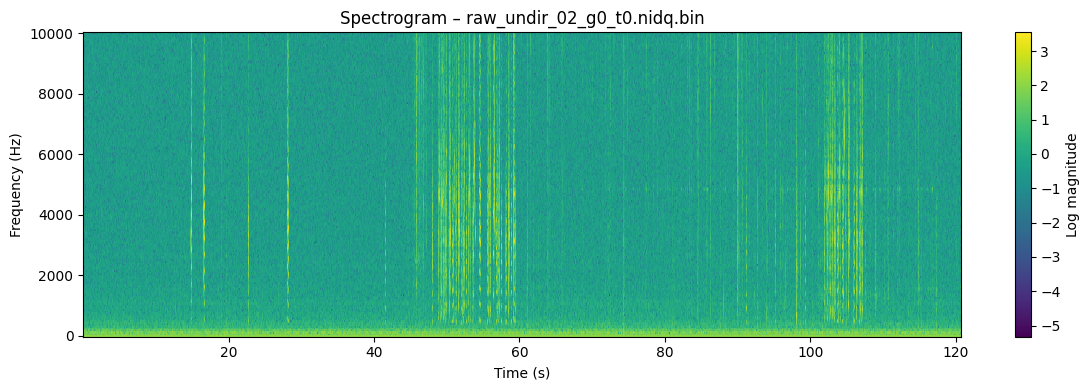

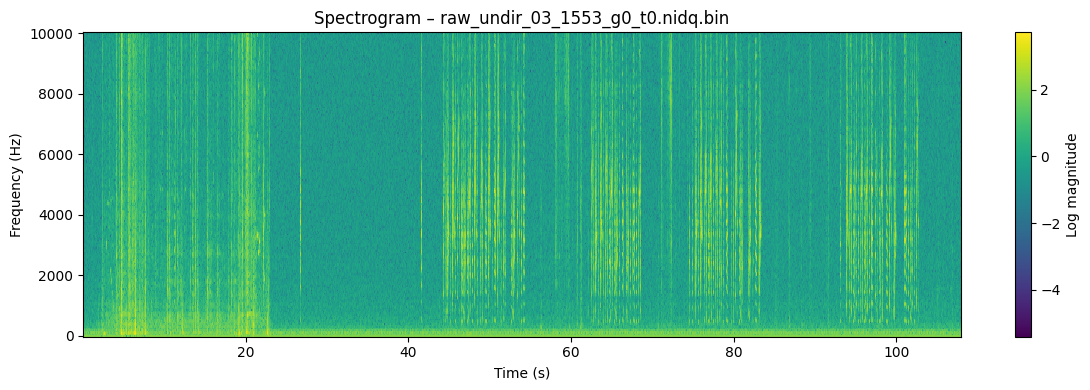

In [ ]:
# for file_id in reconstructed:
#     plot_file_spectrogram(reconstructed, file_id)

# Create 10ms segments

First we figure out how many samples fall into one 10ms segment, given the current sampling rate. We also figure out how many samples this gives us per file/session. We add these two values to our reconstructed values per file.

In [6]:
segment_ms = 10

for file_id in reconstructed:
    sr = reconstructed[file_id]["audio"]["sampling_rate"]
    samples_per_segment = int(round(sr * segment_ms / 1000))
    n_segments = len(reconstructed[file_id]["audio"]["array"]) // samples_per_segment
    
    reconstructed[file_id]["samples_per_segment"] = samples_per_segment
    reconstructed[file_id]["n_segments"] = n_segments

In [1]:
# print(reconstructed["raw_undir_02_g0_t0.nidq.bin"])

### Global variables and helper functions

In [7]:
region_map = {
    "o11y3": {  
        "LMAN": [             
            (210, 270),       
        ],
        "AreaX": [
            (60, 200),       
        ],
        "Pallium": [
            (201, 384),       
        ],
        "Striatum": [
            (1, 200),       
        ],
    },

    "g4r4": {  
        "LMAN": [             
            (240, 280),       
        ],
        "AreaX": [
            (60, 200),       
        ],
        "Pallium": [
            (215, 384),       
        ],
        "Striatum": [
            (1, 214),       
        ],
    },
    
    "r11n11": {  
        "LMAN": [             
            (221, 271),       
        ],
        "AreaX": [
            (71, 201),       
        ],
        "Pallium": [
            (201, 384),       
        ],
        "Striatum": [
            (1, 200),       
        ],
    },
    
    "r14n14": {  
        "LMAN": [             
            (215, 270),       
        ],
        "AreaX": [
            (60, 200),       
        ],
        "Pallium": [
            (207, 384),       
        ],
        "Striatum": [
            (1, 206),       
        ],
    },
    
    "j8v8": {  
        "LMAN": [             
            (230, 300),       
        ],
        "AreaX": [
            (70, 200),       
        ],
        "Pallium": [
            (211, 384),       
        ],
        "Striatum": [
            (1, 210),       
        ],
    },
    
    "r5n5": {  
        "LMAN": [             
            (221, 261),       
        ],
        "AreaX": [
            (51, 191),       
        ],
        "Pallium": [
            (211, 384),       
        ],
        "Striatum": [
            (1, 210),       
        ],
    },
    
    "r15v15": {  
        "LMAN": [             
            (213, 260),       
        ],
        "AreaX": [
            (100, 200),       
        ],
        "Pallium": [
            (201, 384),       
        ],
        "Striatum": [
            (1, 200),       
        ],
    },
}

In [8]:
def channel_to_region(channel, region_def):
    for region, ranges in region_def.items():
        for lo, hi in ranges:
            if lo <= channel < hi:
                return region
    return None

In [9]:
def get_spike_counts_by_region(file_id, start, end):
    bird = reconstructed[file_id]["metadata"]["bird_name"]
    region_def = region_map[bird]

    spike_times = np.asarray(reconstructed[file_id]["spikes"]["time"])
    spike_channels = np.asarray(reconstructed[file_id]["spikes"]["channel"])

    mask = (spike_times >= start) & (spike_times < end)
    seg_channels = spike_channels[mask]

    region_spike_counts = {region: 0 for region in region_def}

    for ch in seg_channels:
        region = channel_to_region(ch, region_def)
        if region is not None:
            region_spike_counts[region] += 1

    return region_spike_counts

### Helpers for saving 10ms segments as pkl/load them if they exist already

In [10]:
SEGMENTS_PKL_DIR = r"chapter_2_1/segments_10ms_pkls"
os.makedirs(SEGMENTS_PKL_DIR, exist_ok=True)

In [11]:
def _safe_session_name(session: str) -> str:
    return session.replace(os.sep, "_")

def _segment_pkl_path(file_id: str, segment_idx: int, out_dir: str) -> str:
    safe_session = _safe_session_name(file_id)
    fname = f"{safe_session}__seg{int(segment_idx):06d}.pkl"
    return os.path.join(out_dir, fname)

def _atomic_pickle_dump(obj, path: str):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fd, tmp_path = tempfile.mkstemp(prefix=os.path.basename(path) + ".", dir=os.path.dirname(path))
    try:
        with os.fdopen(fd, "wb") as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
        os.replace(tmp_path, path)
    except Exception:
        try:
            os.remove(tmp_path)
        except OSError:
            pass
        raise

### Aggregate data for each 10ms segment

In [16]:
segments_10ms = []

for file_id in reconstructed:
    spike_times = np.asarray(reconstructed[file_id]["spikes"]["time"])
    for i in range(reconstructed[file_id]["n_segments"]):
        # --- cache hit ---
        pkl_path = _segment_pkl_path(file_id, i, out_dir=SEGMENTS_PKL_DIR)
        if os.path.exists(pkl_path):
            try:
                with open(pkl_path, "rb") as f:
                    seg = pickle.load(f)
                segments_10ms.append(seg)
                continue
            except Exception:
                pass

        # --- cache miss ---
        start = i * reconstructed[file_id]["samples_per_segment"]
        end = start + reconstructed[file_id]["samples_per_segment"]

        # compute spike counts
        total_spike_count = np.sum((spike_times >= start) & (spike_times < end))    # TOTAL
        region_spike_counts = get_spike_counts_by_region(file_id, start, end)       # REGION
        total_spike_counts_by_lag = [0, 0, 0, 0, 0]                                 # LAGS OF TOTAL
        region_spike_counts_by_lag = defaultdict(Counter)                           # LAGS OF REGION
        for lag in range(5):                                                  
            if lag + 1 > i:
                continue
            else:
                total_spike_counts_by_lag[lag] = segments_10ms[i - lag - 1]["total_spike_count"]
                region_spike_counts_by_lag[lag] = dict(Counter(segments_10ms[i - lag - 1]["region_spike_counts"]))

        # get all cluster ids that have been given to samples that fall within this 10ms segment
        cluster_ids_list = []
        for row in rows_by_file[file_id]:     
            row_start = row["onset_sample"]
            row_end = row["onset_sample"] + row["duration_samples"]

            if (row_end > start) and (end > row_start):
                cluster_ids_list.append(row["cluster_id"])
        cluster_ids = np.array(cluster_ids_list)

        # STFT frames whose centers fall inside this 10ms bin
        S = reconstructed[file_id]["stft_data"]["S"]  
        frame_centers = reconstructed[file_id]["stft_data"]["frame_centers_sample"]
        frame_mask = (frame_centers >= start) & (frame_centers < end)
        stft_frames = S[:, frame_mask]

        segment = {
            "bird_name": reconstructed[file_id]["metadata"]["bird_name"],
            "session": file_id,
            "segment_idx": i,
            "start_sample": start,
            "end_sample": end,
            "total_spike_count": total_spike_count,
            "region_spike_counts": region_spike_counts,
            "total_spike_counts_by_lag": total_spike_counts_by_lag,
            "region_spike_counts_by_lag": region_spike_counts_by_lag,
            "cluster_ids": cluster_ids,
            "stft_frames": stft_frames
        }

        segments_10ms.append(segment)
        _atomic_pickle_dump(segment, pkl_path)

In [18]:
# print(segments_10ms[7])

### Some more plotting stuff as sanity check

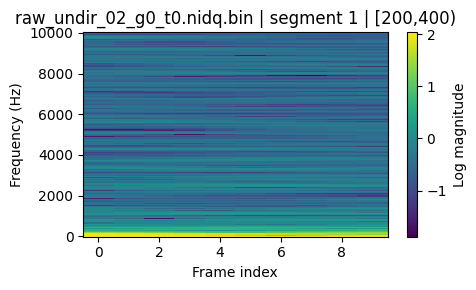

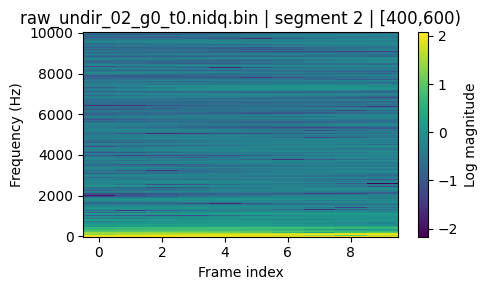

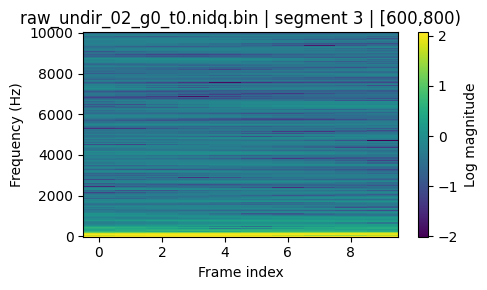

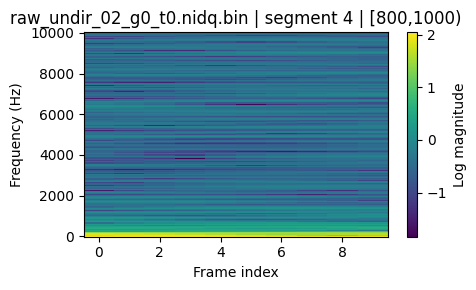

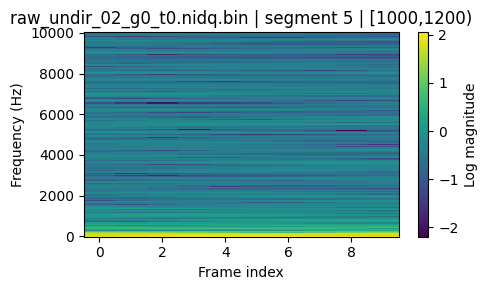

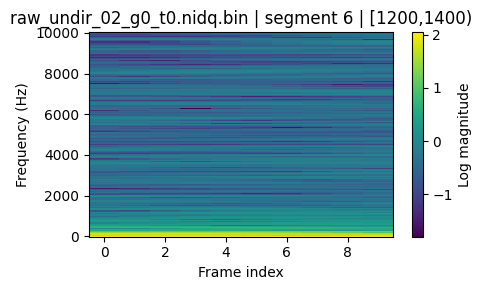

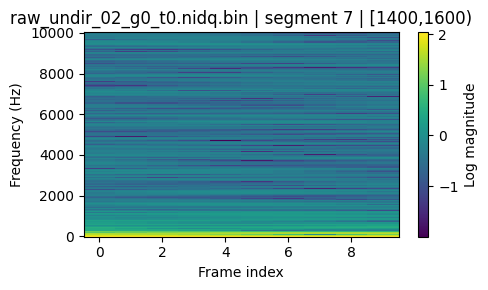

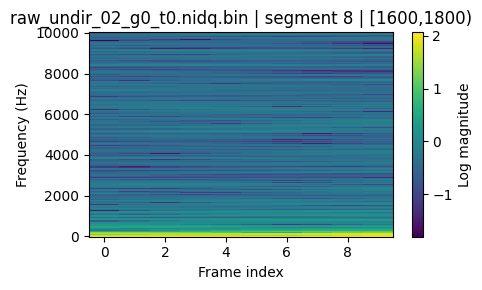

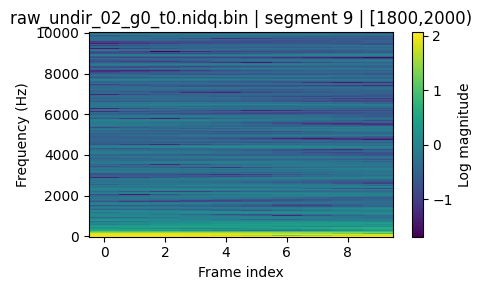

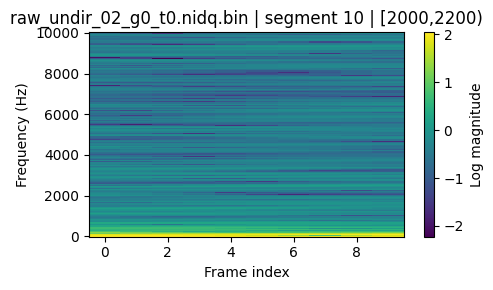

In [ ]:
# def plot_10_segment_spectrograms(segments_10ms, reconstructed, file_id=None, n=10, log_scale=True):
#     # pick a file if none provided
#     if file_id is None:
#         file_id = next(iter(reconstructed))

#     sr = reconstructed[file_id]["audio"]["sampling_rate"]
#     freqs = reconstructed[file_id]["stft_data"].get("freqs_hz", None)

#     # collect segments for this file that actually have STFT frames
#     segs = [s for s in segments_10ms
#             if s["session"] == file_id and "stft_frames" in s and s["stft_frames"].shape[1] > 0]

#     if not segs:
#         print(f"No segments with non-empty stft_frames for file {file_id}")
#         return

#     for s in segs[:n]:
#         S = s["stft_frames"]
#         # log scaling for visibility (works for magnitude or power)
#         Z = np.log10(S + 1e-12) if log_scale else S

#         # x-axis: frame center times relative to segment start (ms), if available
#         if "stft_frame_centers_sample" in s and len(s["stft_frame_centers_sample"]) == S.shape[1]:
#             x_ms = (np.asarray(s["stft_frame_centers_sample"]) - s["start_sample"]) / sr * 1000.0
#             x_label = "Time within segment (ms)"
#         else:
#             x_ms = np.arange(S.shape[1])
#             x_label = "Frame index"

#         y = freqs if freqs is not None else np.arange(S.shape[0])
#         y_label = "Frequency (Hz)" if freqs is not None else "Frequency bin"

#         plt.figure(figsize=(5, 3))
#         plt.pcolormesh(x_ms, y, Z, shading="auto")
#         plt.xlabel(x_label)
#         plt.ylabel(y_label)
#         plt.title(f"{file_id} | segment {s['segment_idx']} | [{s['start_sample']},{s['end_sample']})")
#         plt.colorbar(label="Log magnitude" if log_scale else "Magnitude")
#         plt.tight_layout()
#         plt.show()

# plot_10_segment_spectrograms(segments_10ms, reconstructed, file_id=None, n=10, log_scale=True)


# Assign each 10ms segment to "low spike count" or "high spike count" based on selected group conditions

In [22]:
def split_segments_high_low(
    segments_10ms,
    want_cluster=False,
    want_region=False,
    want_cluster_region=False,
    want_population=True,
    q_lo=1/3,
    q_hi=2/3,
    lags=None
):
    low = {}
    high = {}

    groups = defaultdict(list)
    lags_iter = [None] + ([] if lags is None else list(lags))

    for s in segments_10ms:
        bird = s["bird_name"]
        cids = np.asarray(s["cluster_ids"]).tolist()

        for lag in lags_iter:
            total = (s["total_spike_count"] if lag is None else s["total_spike_counts_by_lag"][lag])
            rcounts = (s.get("region_spike_counts", {}) if lag is None else s["region_spike_counts_by_lag"].get(lag, {}))

            def get_current_group_key(kind):
                return (bird, kind) if lag is None else (bird, kind, lag)

            if want_population:
                groups[get_current_group_key("population")].append((s, float(total)))

            if want_cluster:
                for cid in cids:
                    groups[get_current_group_key(("cluster", int(cid)))].append((s, float(total)))

            if want_region:
                for region in ("LMAN", "AreaX", "Pallium", "Striatum"):
                    groups[get_current_group_key(("region", region))].append((s, float(rcounts.get(region, 0))))

            if want_cluster_region:
                for cid in cids:
                    cid = int(cid)
                    for region in ("LMAN", "AreaX", "Pallium", "Striatum"):
                        groups[get_current_group_key(("cluster_region", cid, region))].append((s, float(rcounts.get(region, 0))))

    for key, seg_and_val in groups.items():
        vals = np.array([v for _, v in seg_and_val], dtype=float)

        lo, hi = np.quantile(vals, [q_lo, q_hi])

        # exclude keys with 0 segments assigned to it
        low_segs = [seg for seg, v in seg_and_val if v <= lo]
        high_segs = [seg for seg, v in seg_and_val if v >= hi]
        if len(low_segs) == 0 and len(high_segs) == 0:
            continue

        low[key] = low_segs
        high[key] = high_segs

    return low, high

In [21]:
def average_stft(segments):
    frames = [s["stft_frames"] for s in segments if s["stft_frames"].size > 0]
    if not frames:
        return None

    F = frames[0].shape[0]
    frames = [x for x in frames if x.shape[0] == F]
    T_common = min(x.shape[1] for x in frames)

    X = np.stack([x[:, :T_common] for x in frames], axis=0) 
    return X.mean(axis=0)
 
def average_stft_high_low(low_segments_by_bird, high_segments_by_bird):
    avg_spec_time_low = {}
    avg_spec_time_high = {}

    for bird in low_segments_by_bird:
        avg_spec_time_low[bird] = average_stft(low_segments_by_bird[bird])
        avg_spec_time_high[bird] = average_stft(high_segments_by_bird.get(bird, []))

    return avg_spec_time_low, avg_spec_time_high

In [30]:
def plot_avg_low_high_spectrograms(
    bird,
    avg_spec_time_low,
    avg_spec_time_high,
    reconstructed,
    group_key,
    log_scale=True
):
    # --- build title from key ---
    if len(group_key) == 3:
        _, kind, lag = group_key
    else:
        _, kind = group_key
        lag = None

    if lag == None:
        lag = -1
    if kind == "population":
        title_str = f"{bird} – population – lag {(lag + 1)*10} ms"
    elif kind[0] == "cluster":
        title_str = f"{bird} – cluster {kind[1]} – lag {(lag + 1)*10} ms"
    elif kind[0] == "region":
        title_str = f"{bird} – region {kind[1]} – lag {(lag + 1)*10} ms"
    elif kind[0] == "cluster_region":
        _, cid, region = kind
        title_str = f"{bird} – cluster {cid}, {region} – lag {(lag + 1)*10} ms"
    else:
        title_str = f"{bird} – {kind} – lag {(lag + 1)*10} ms"

    S_low = avg_spec_time_low.get(bird)
    S_high = avg_spec_time_high.get(bird)

    if S_low is None or S_high is None:
        print(f"Missing low/high spectrograms for bird {bird}")
        return

    file_id = next(
        fid for fid in reconstructed
        if reconstructed[fid]["metadata"]["bird_name"] == bird
    )
    freqs = reconstructed[file_id]["stft_data"]["freqs_hz"]

    Z_low = np.log10(S_low + 1e-12) if log_scale else S_low
    Z_high = np.log10(S_high + 1e-12) if log_scale else S_high
    
    min_hz = 100
    mask = freqs >= min_hz

    Z_low_plot = Z_low[mask, :]
    Z_high_plot = Z_high[mask, :]
    freqs_plot = freqs[mask]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    fig.suptitle(title_str, fontsize=14, y=0.98)

    im0 = axes[0].pcolormesh(Z_low_plot, shading="auto")
    axes[0].set_title("LOW spike count")
    axes[0].set_xlabel("Time (frames)")
    axes[0].set_ylabel("Frequency (Hz)")
    axes[0].set_yticks(np.linspace(0, len(freqs_plot) - 1, 6))
    axes[0].set_yticklabels(np.round(np.linspace(freqs_plot[0], freqs_plot[-1], 6)).astype(int))

    im1 = axes[1].pcolormesh(Z_high_plot, shading="auto")
    axes[1].set_title("HIGH spike count")
    axes[1].set_xlabel("Time (frames)")

    cbar = fig.colorbar(im1, ax=axes, fraction=0.025, location="right")
    cbar.set_label("Log magnitude" if log_scale else "Magnitude")

    plt.show()

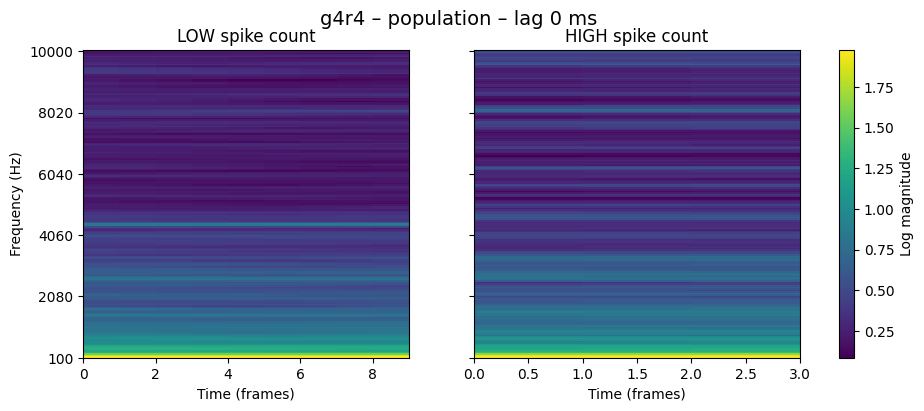

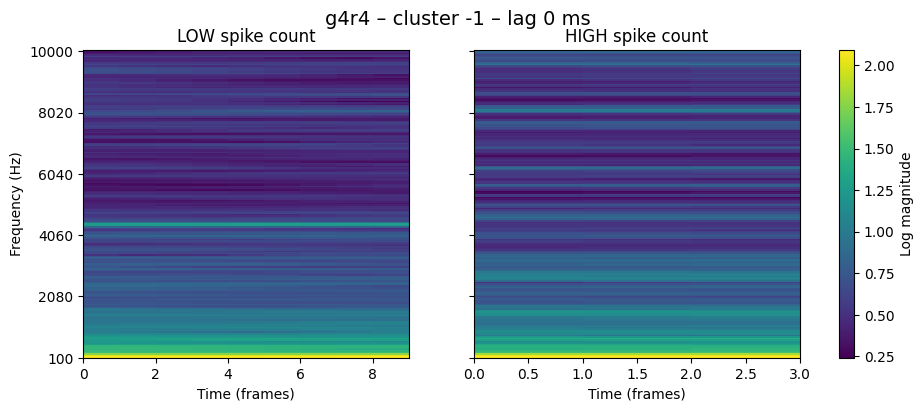

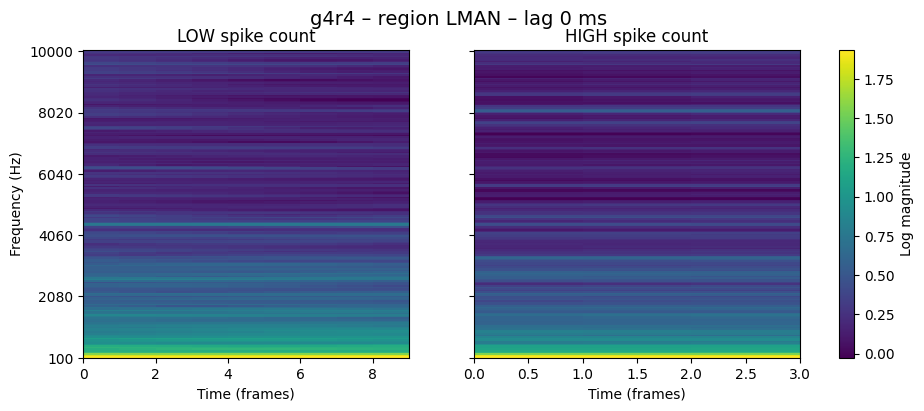

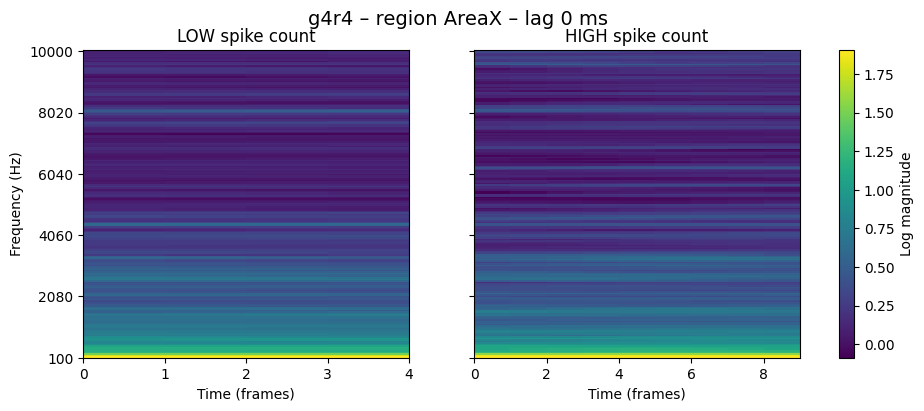

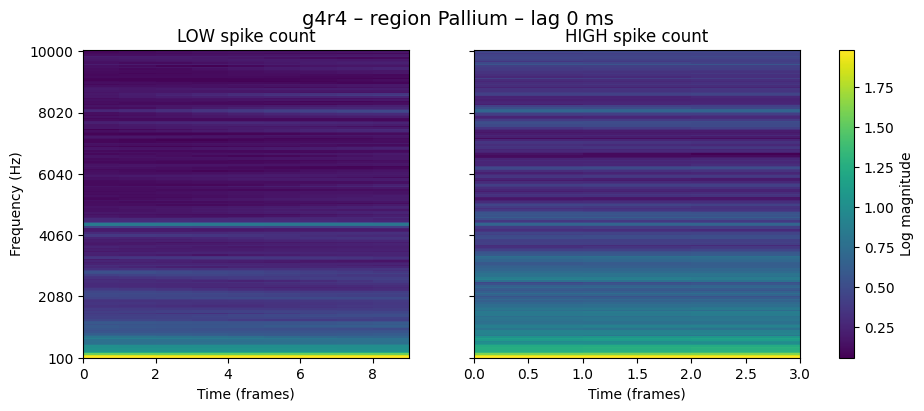

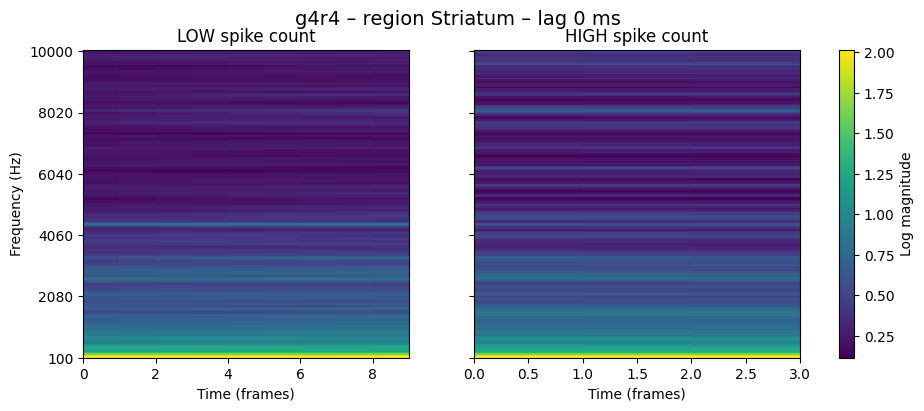

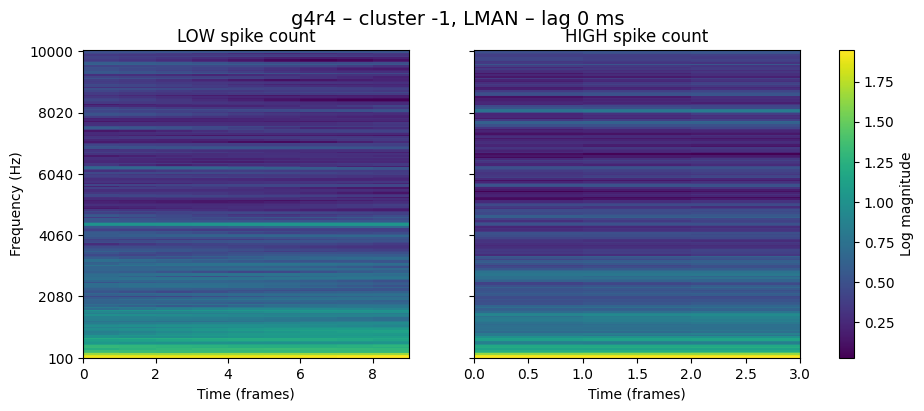

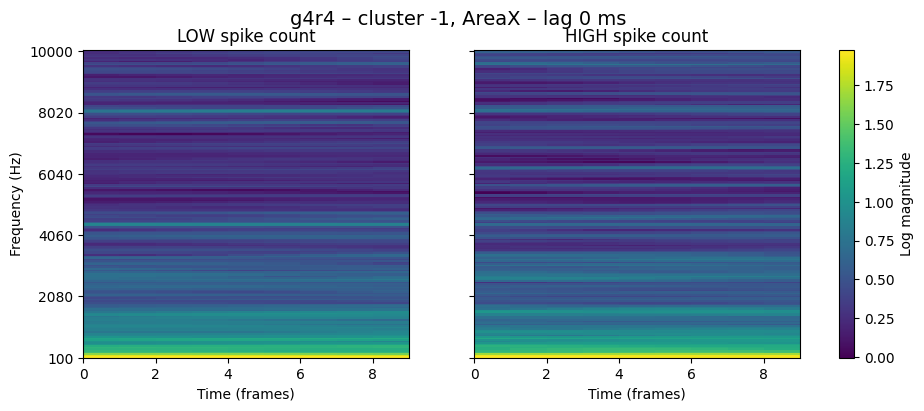

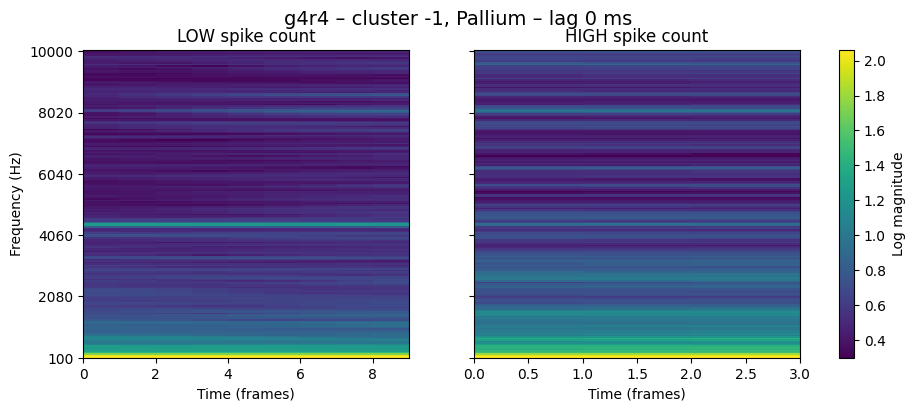

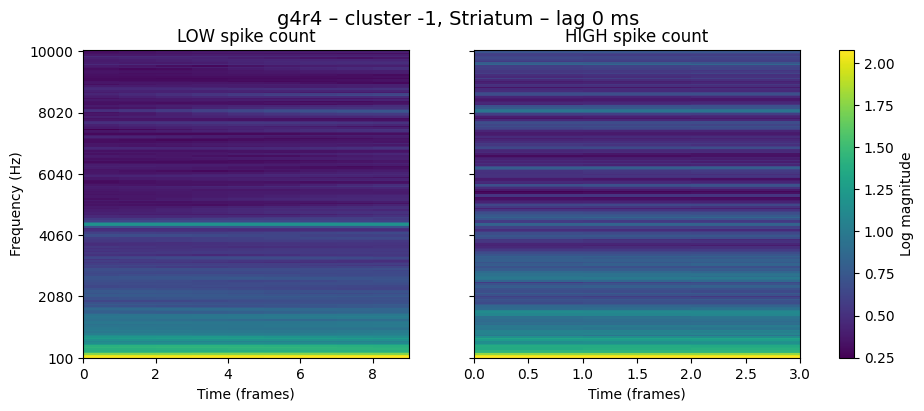

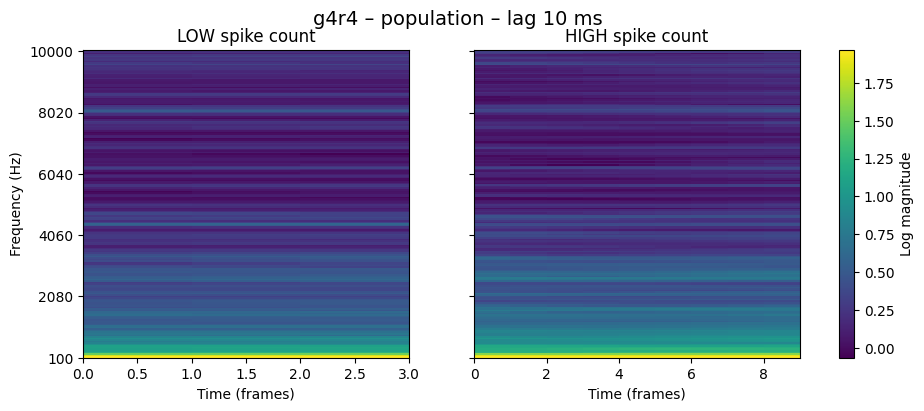

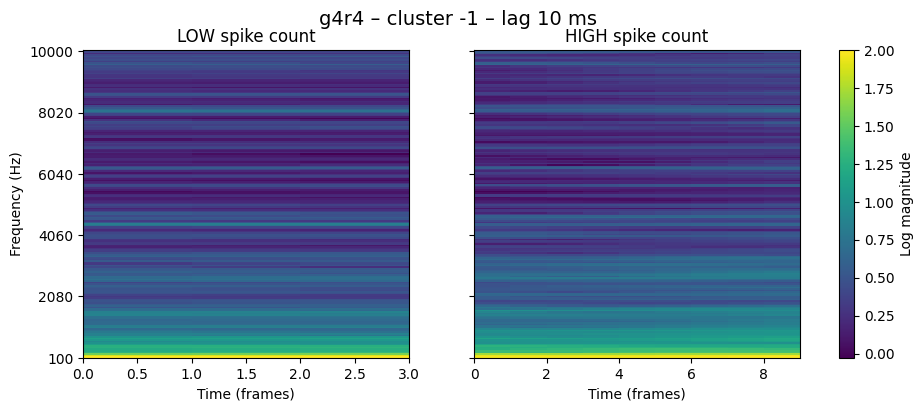

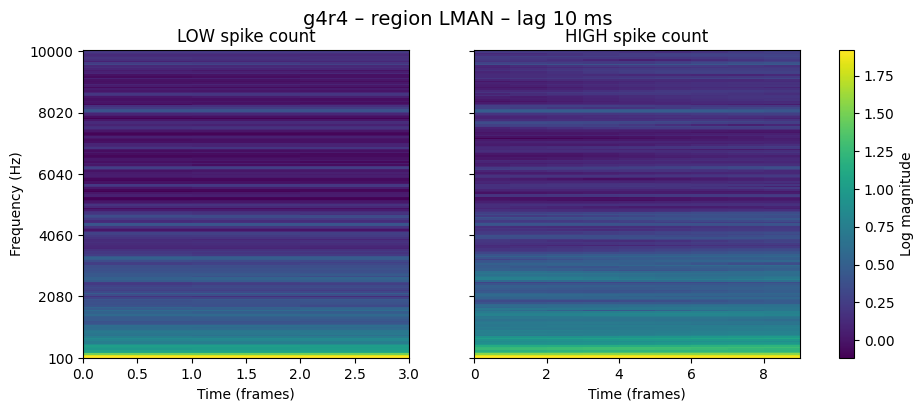

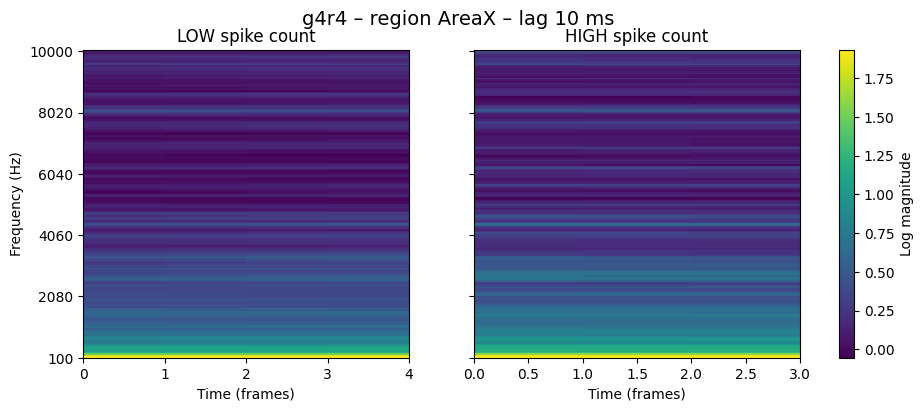

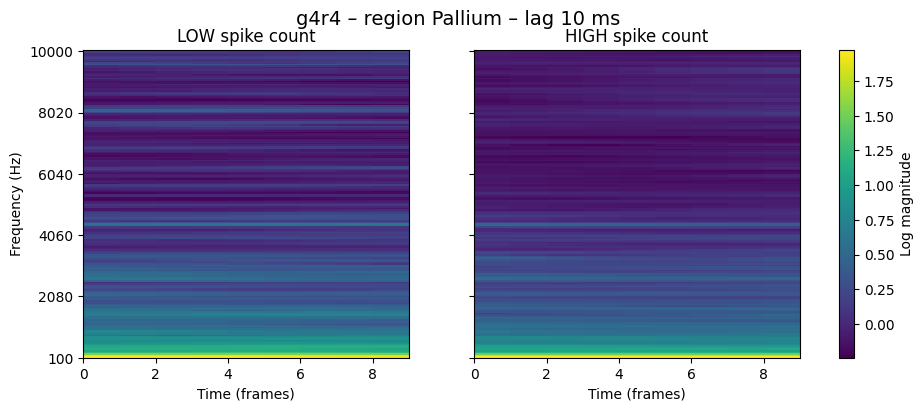

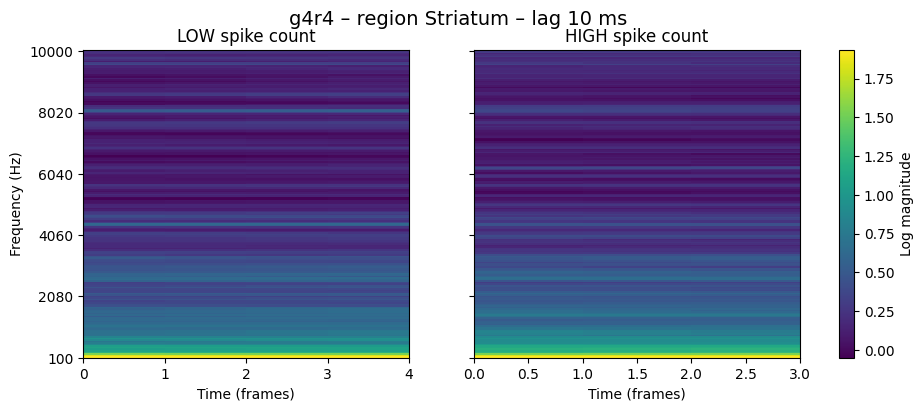

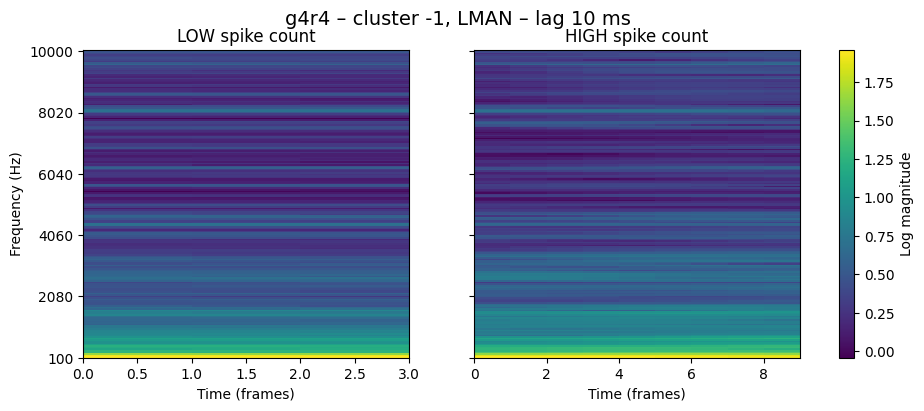

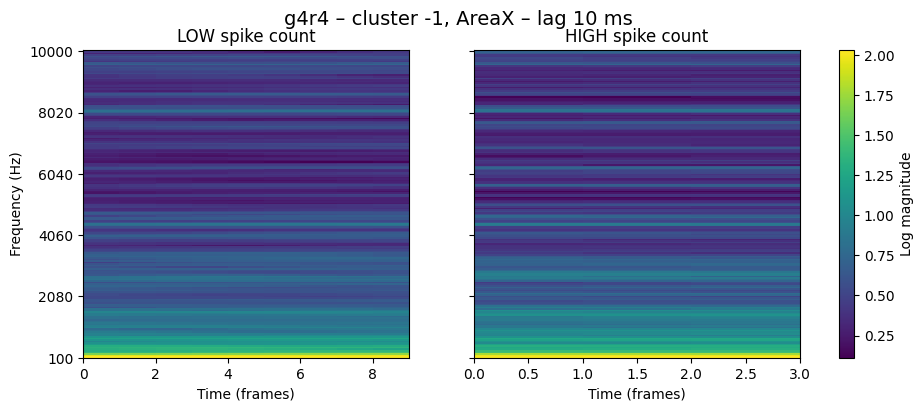

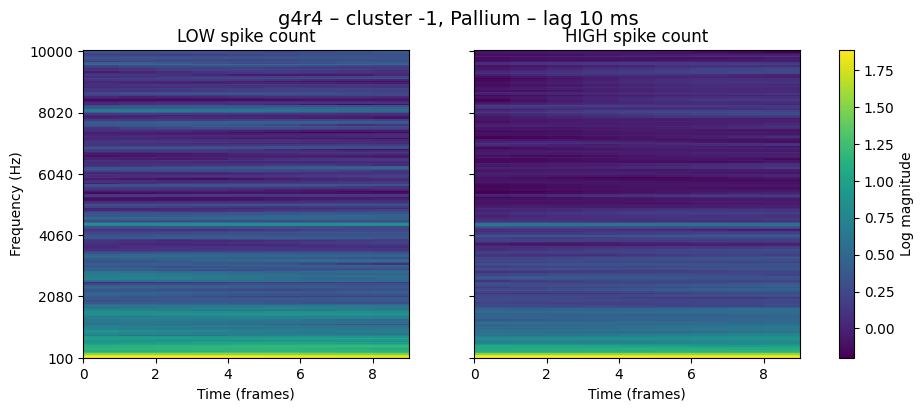

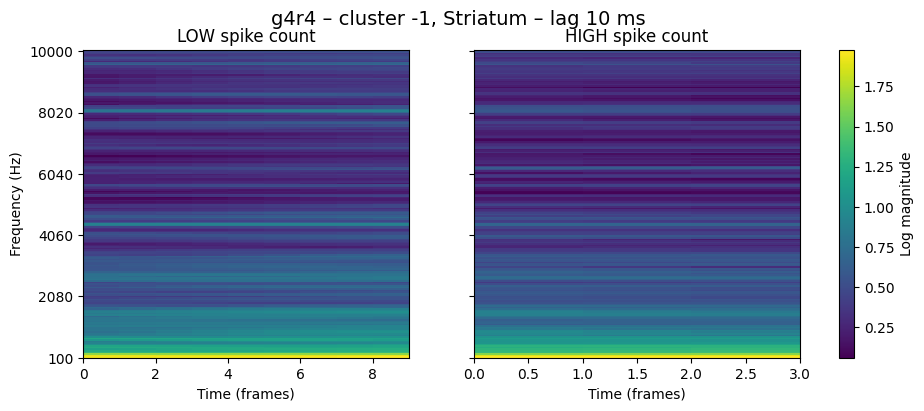

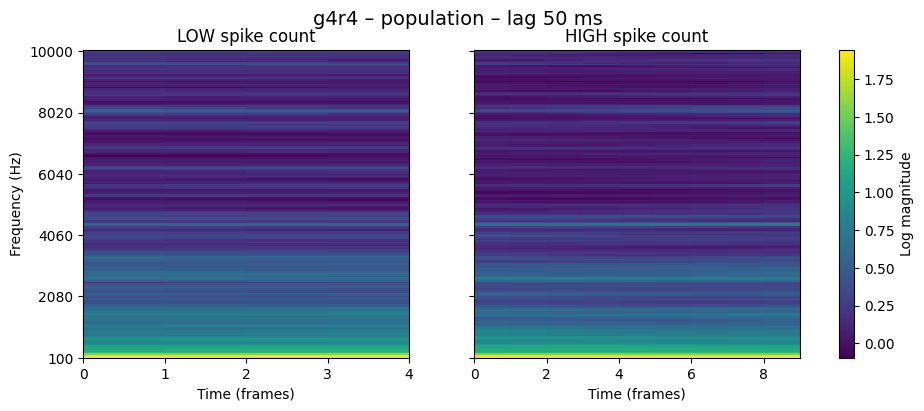

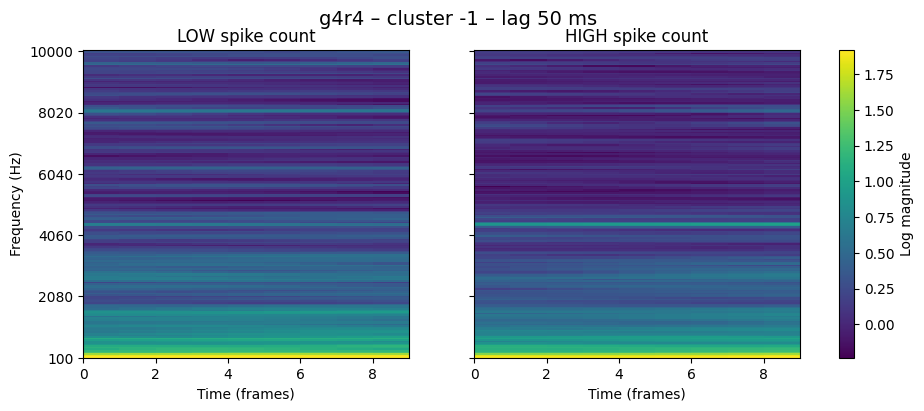

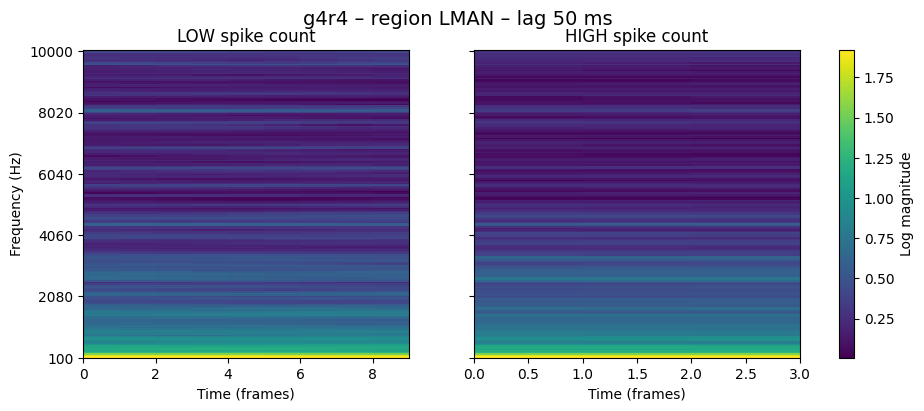

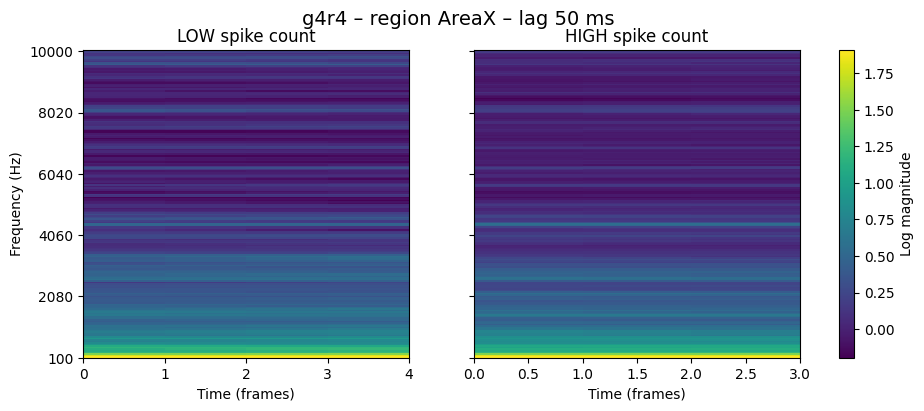

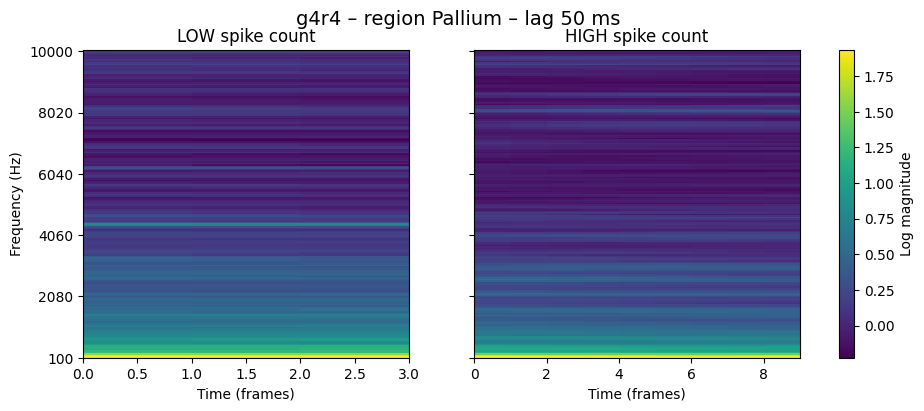

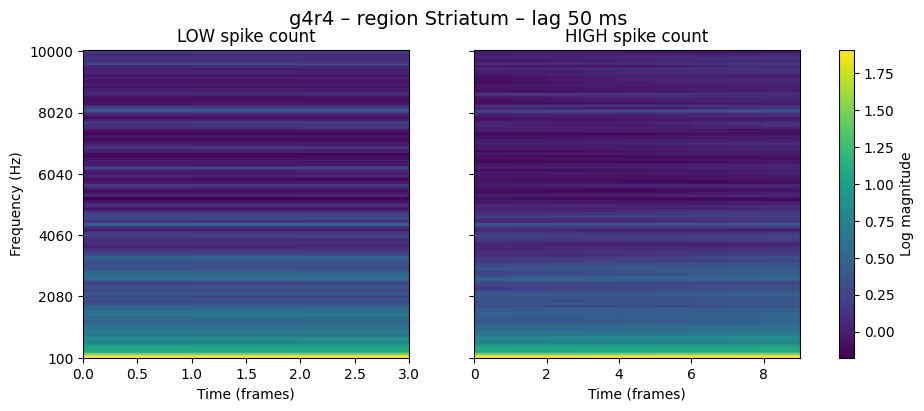

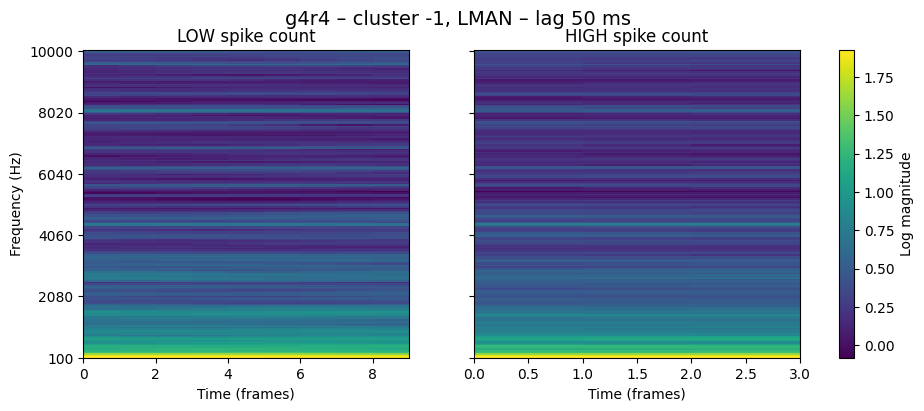

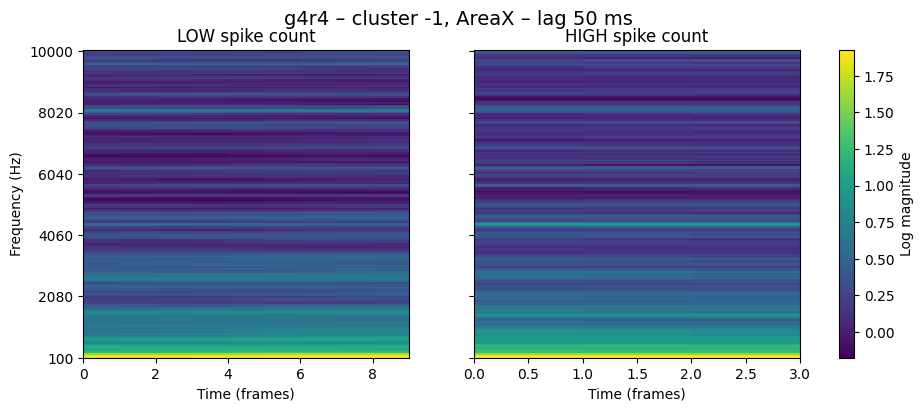

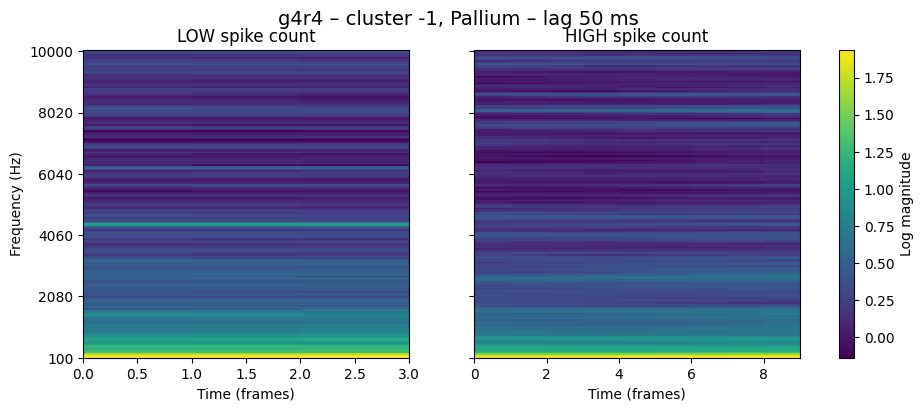

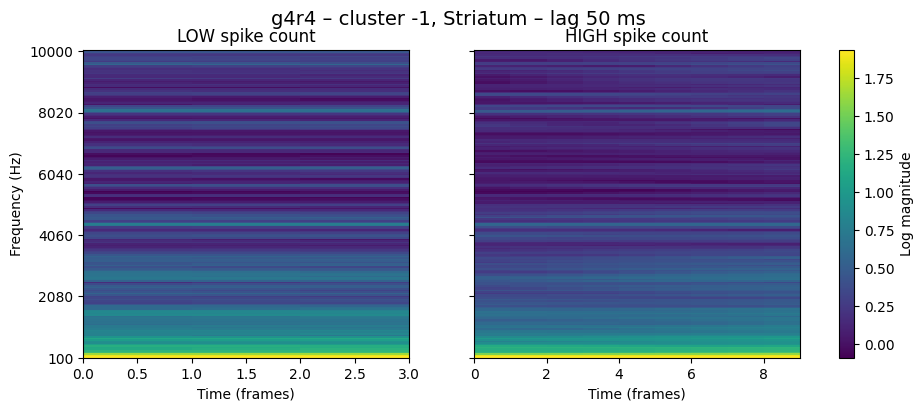

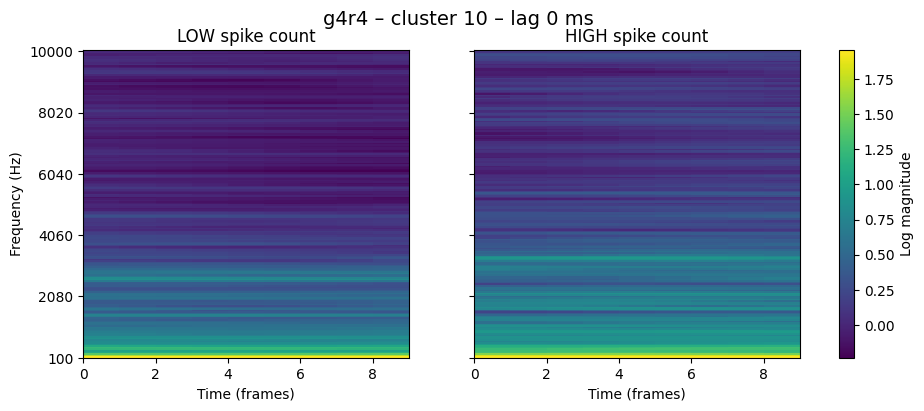

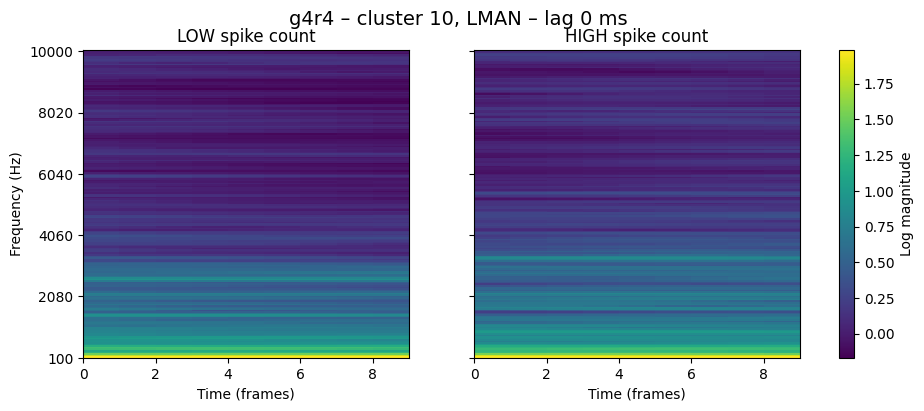

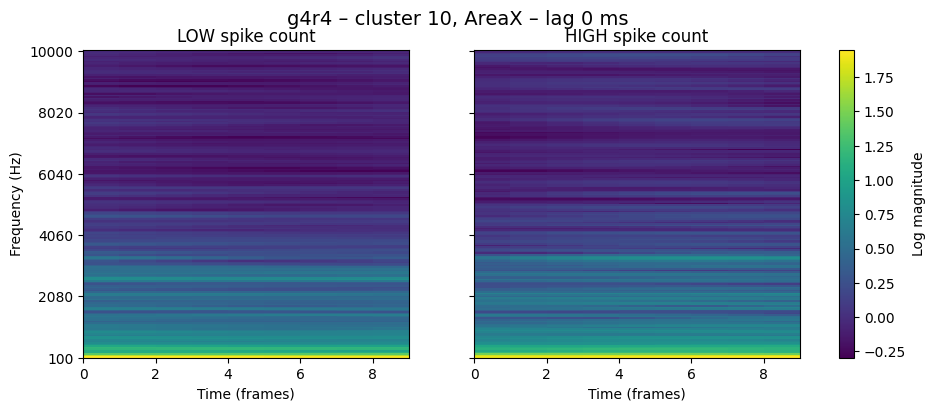

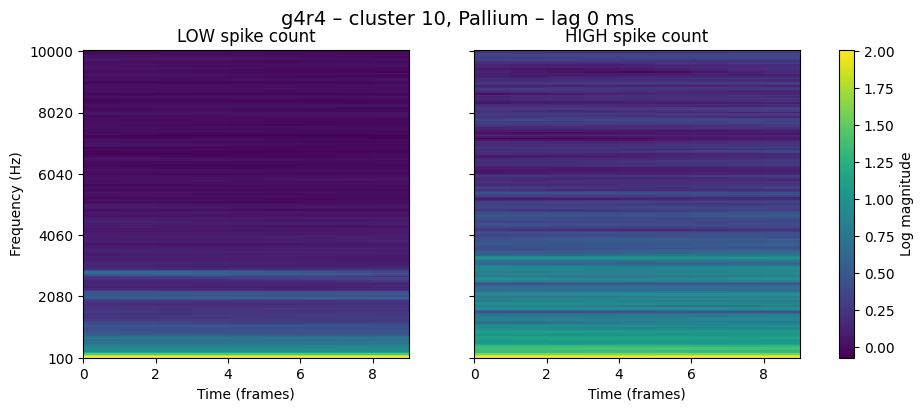

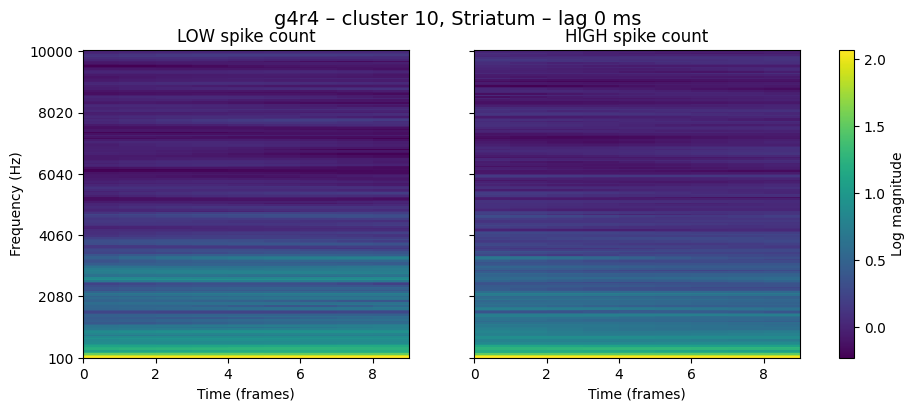

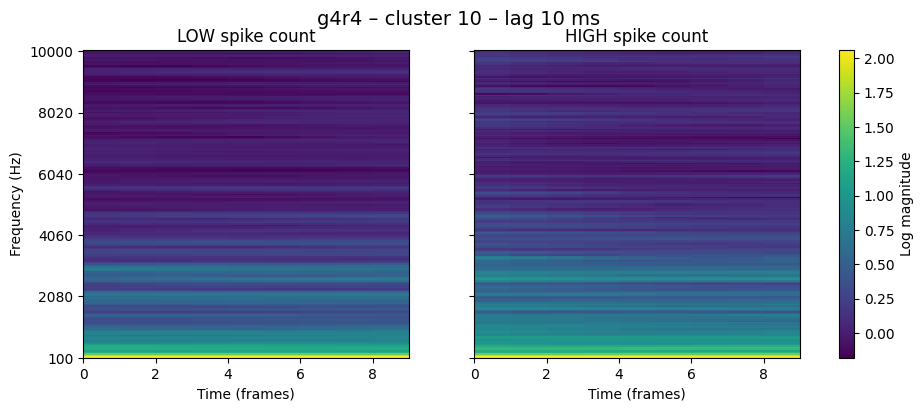

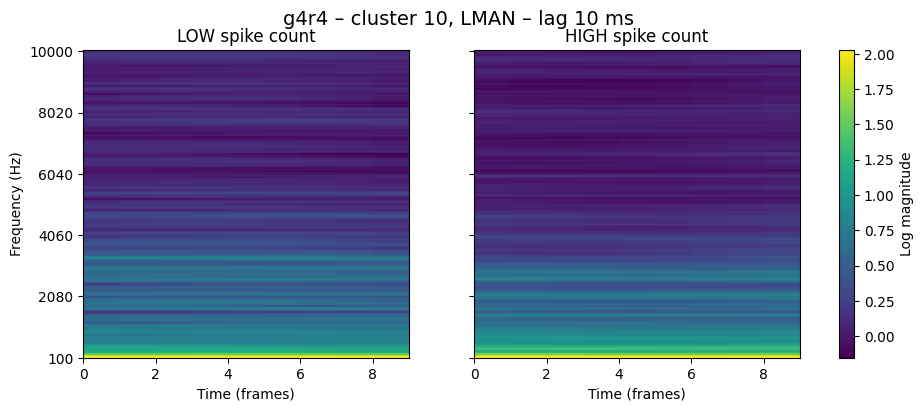

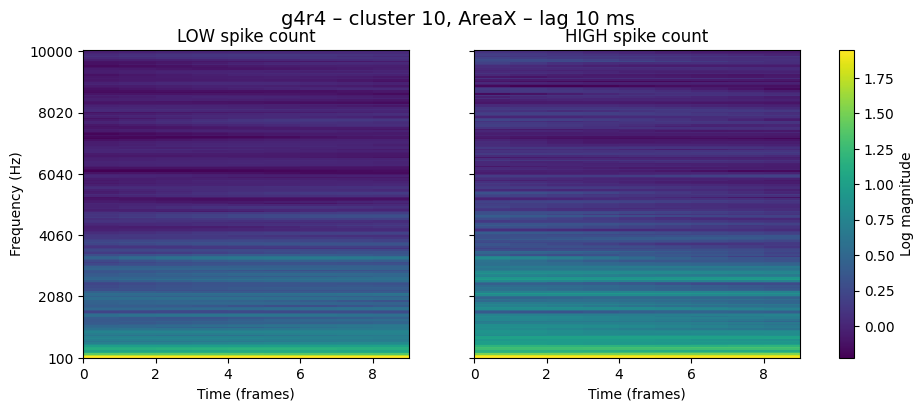

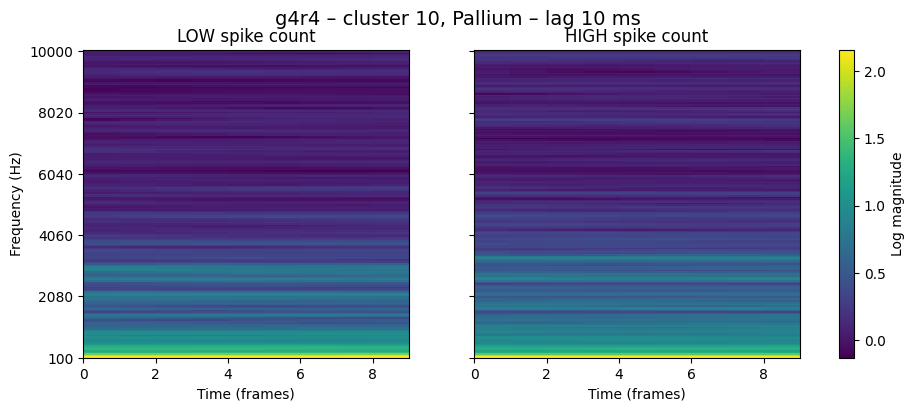

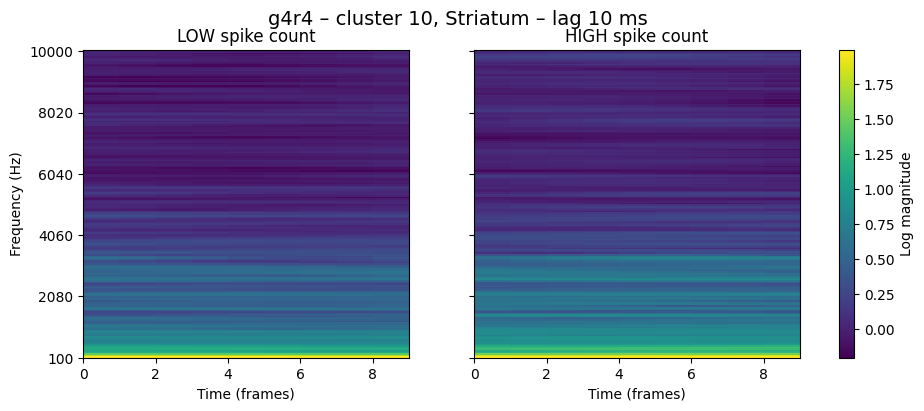

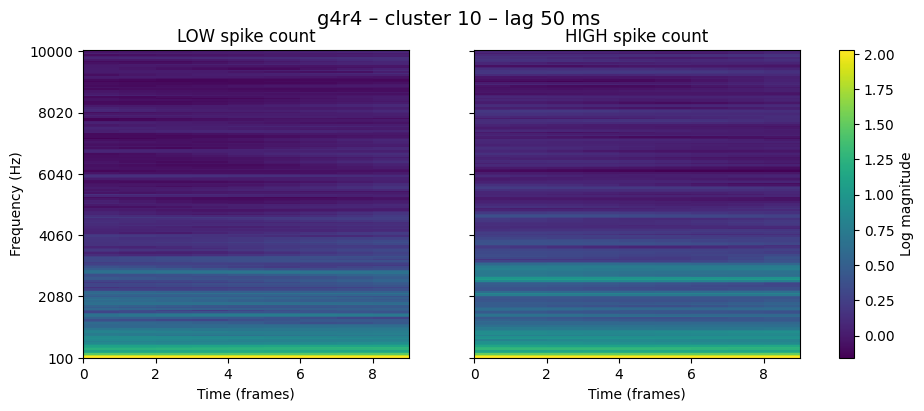

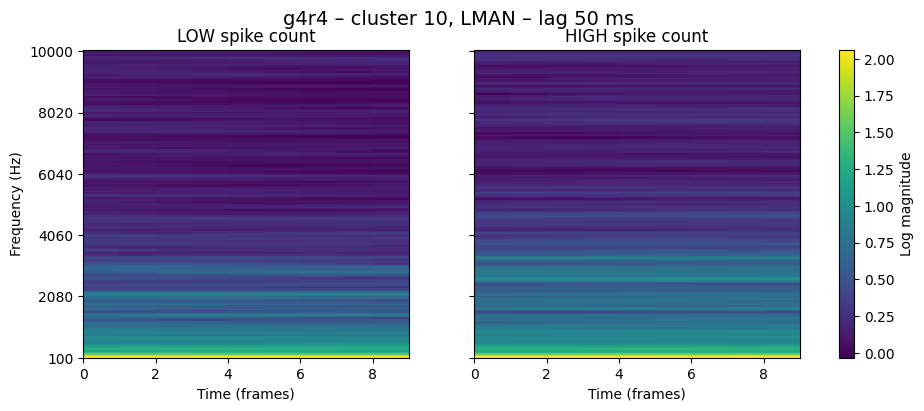

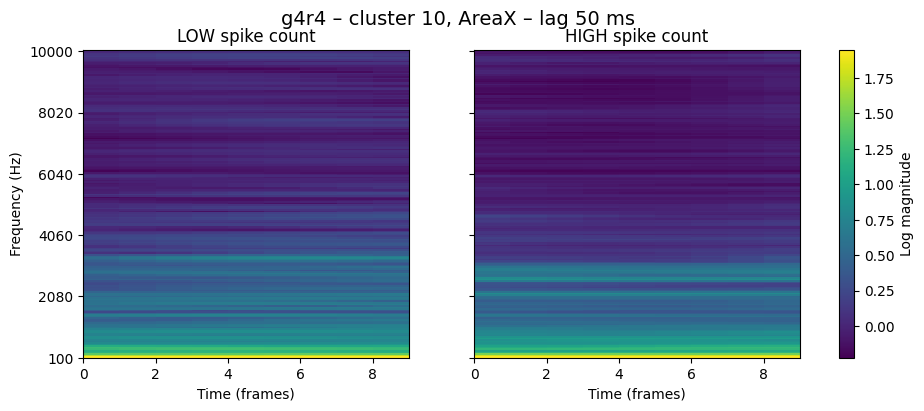

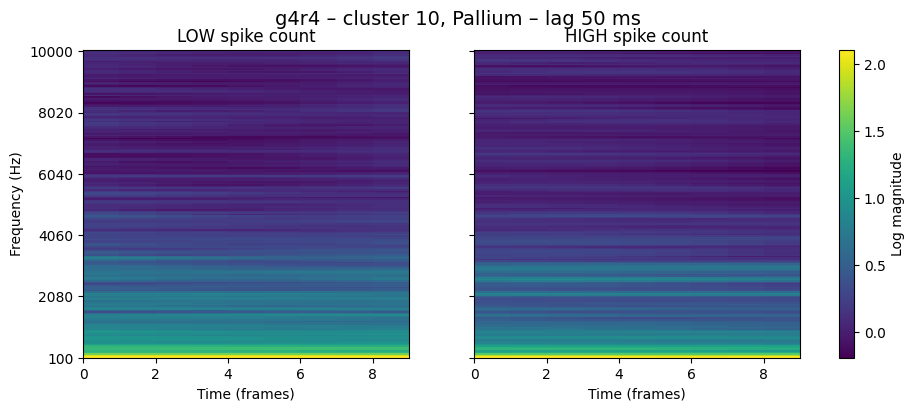

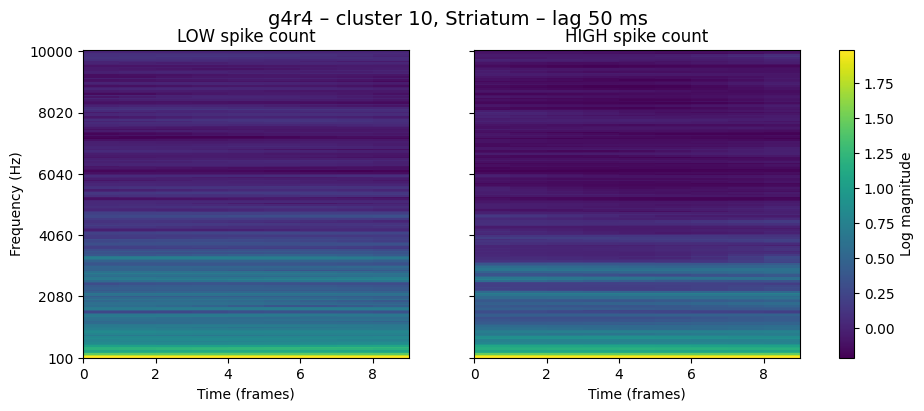

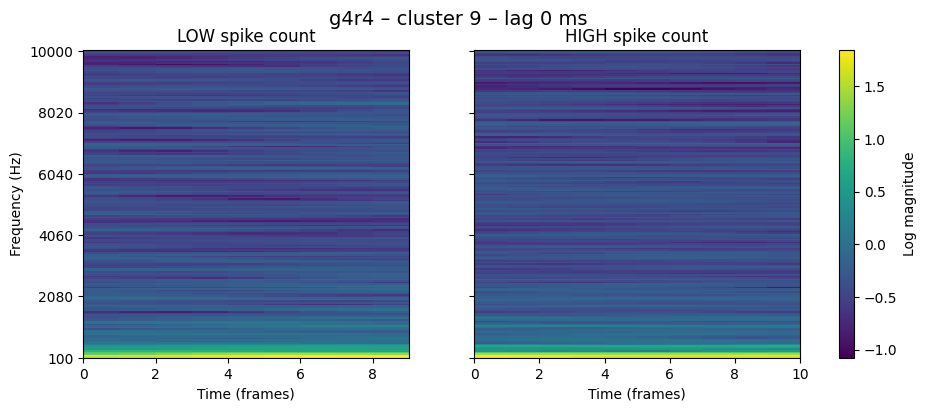

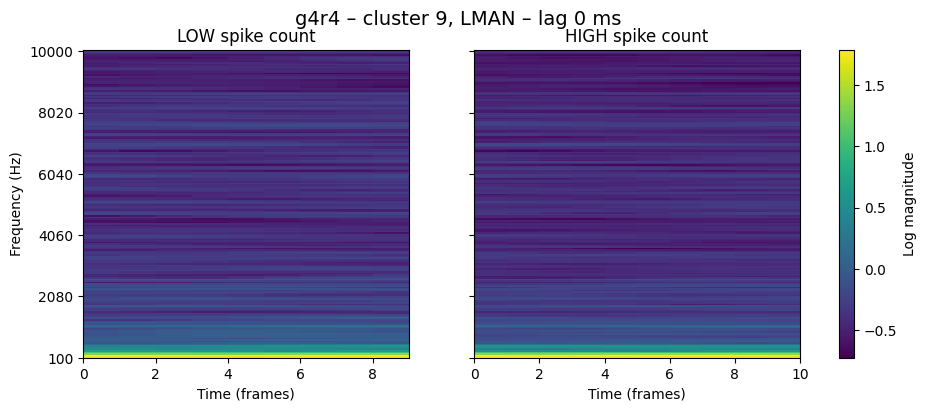

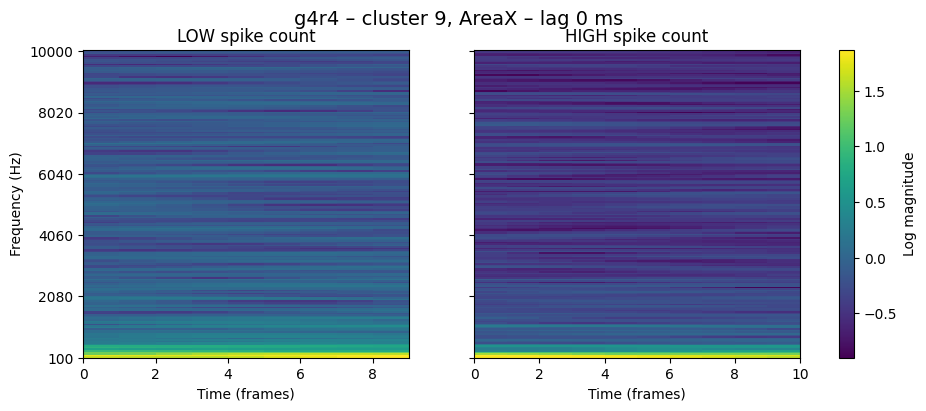

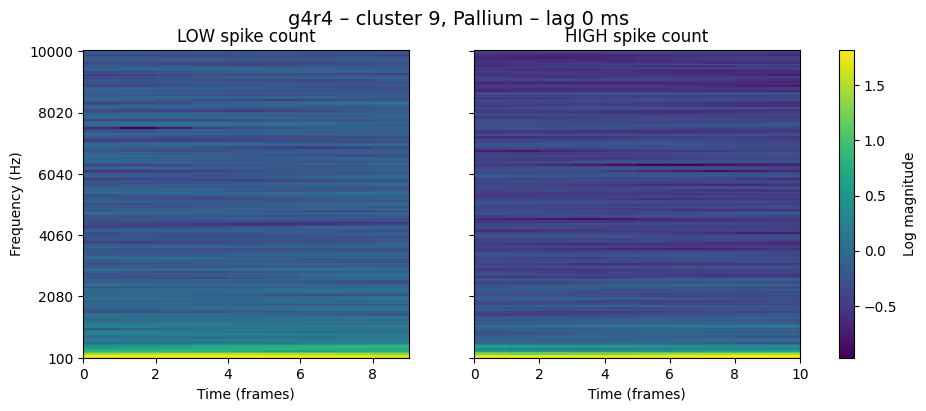

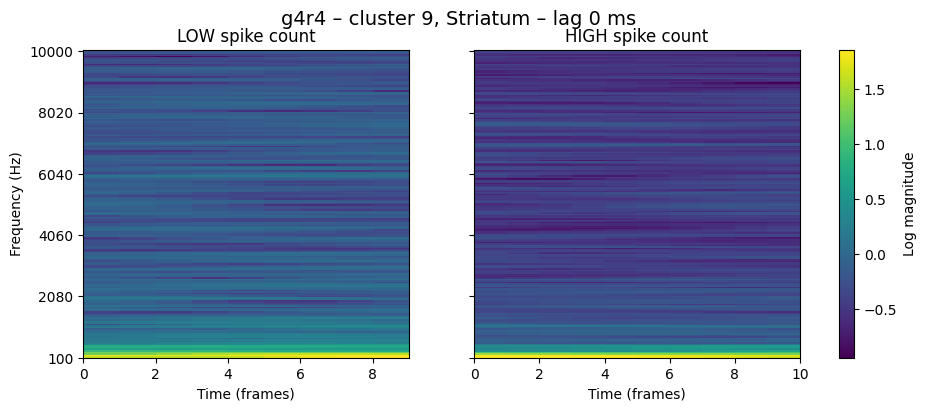

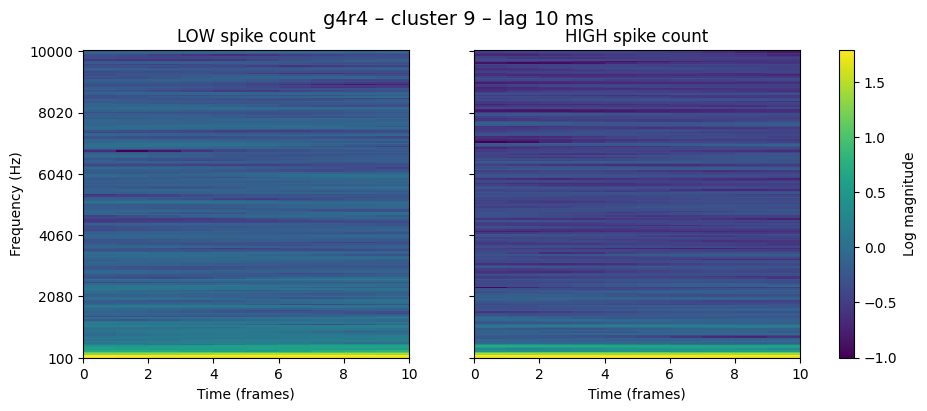

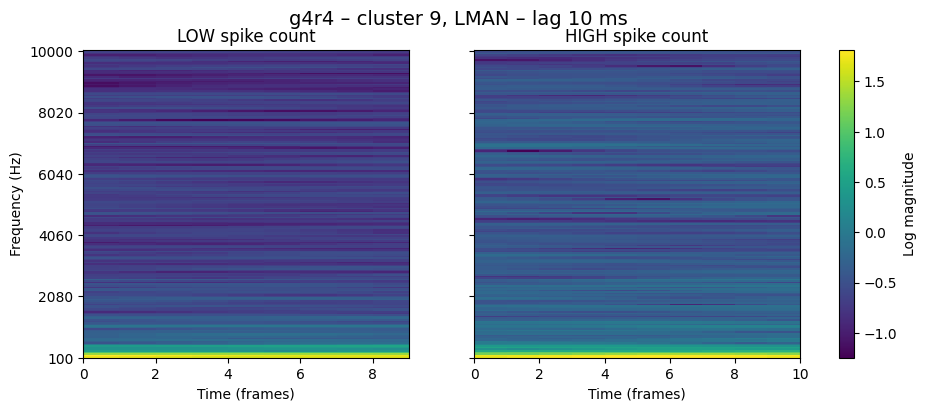

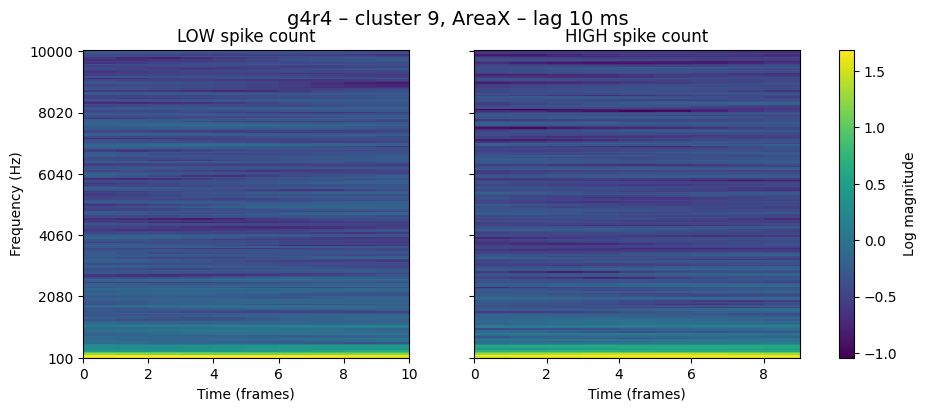

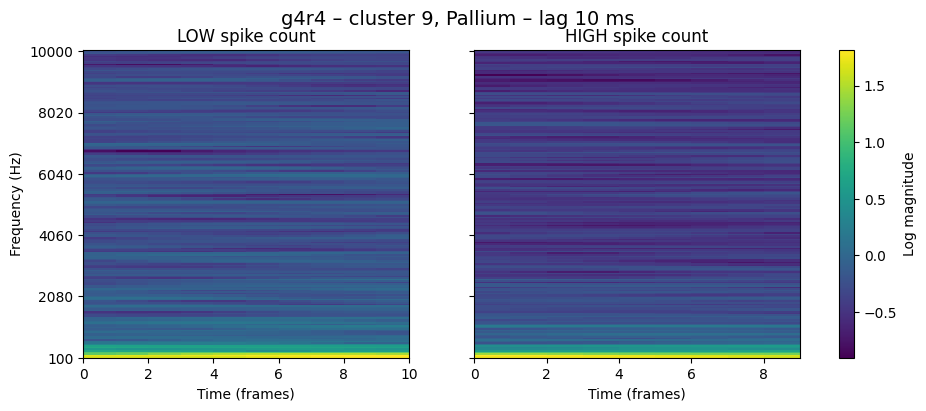

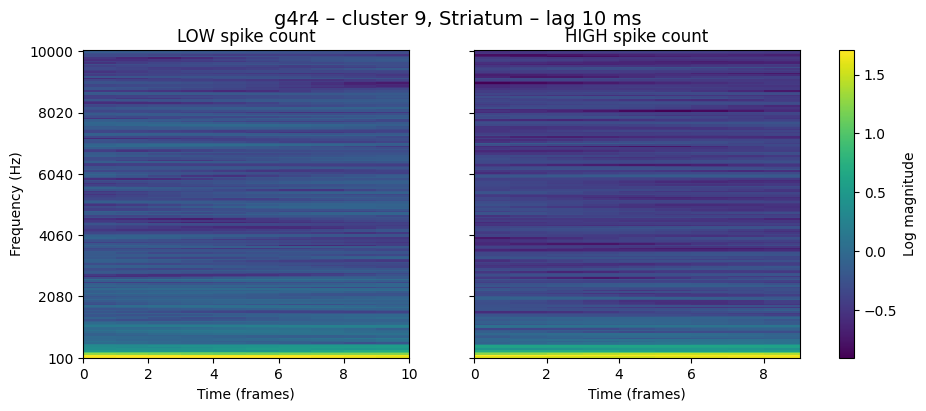

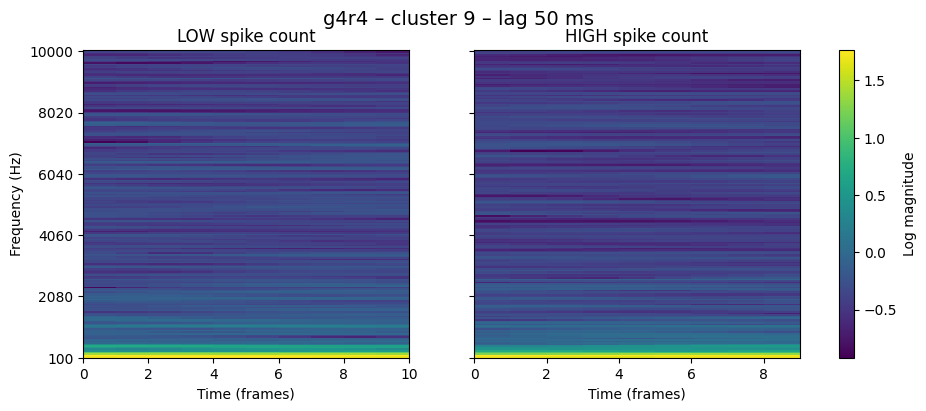

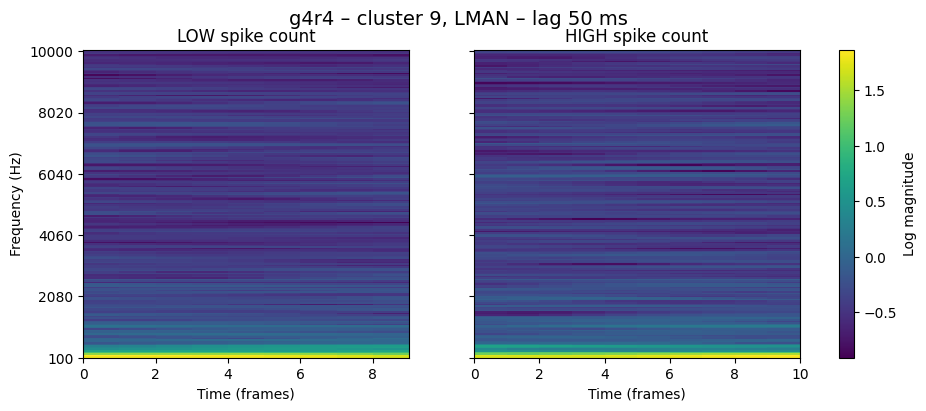

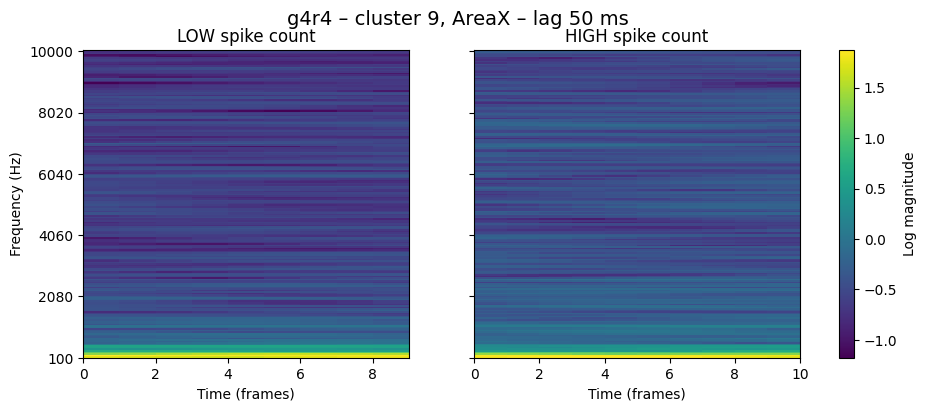

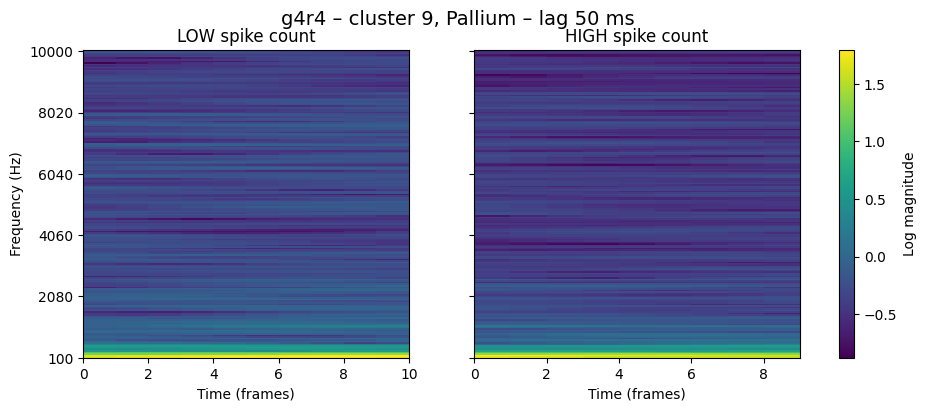

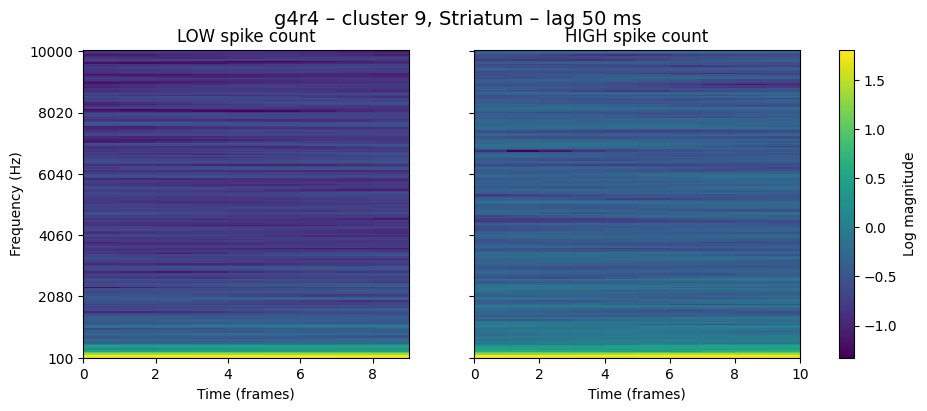

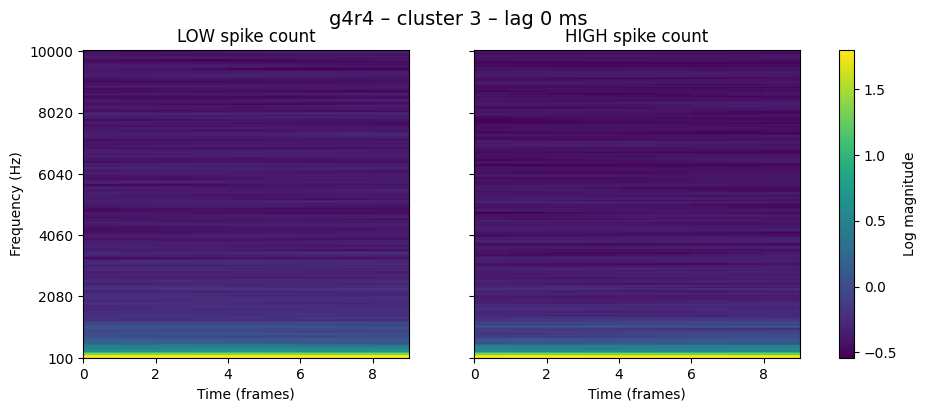

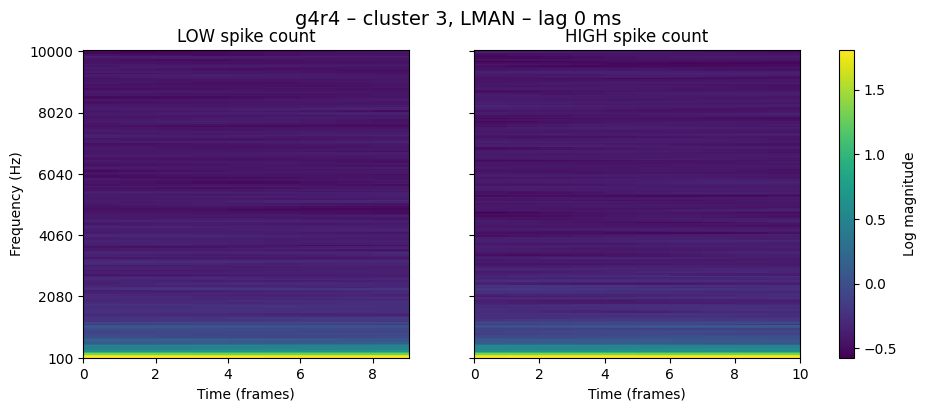

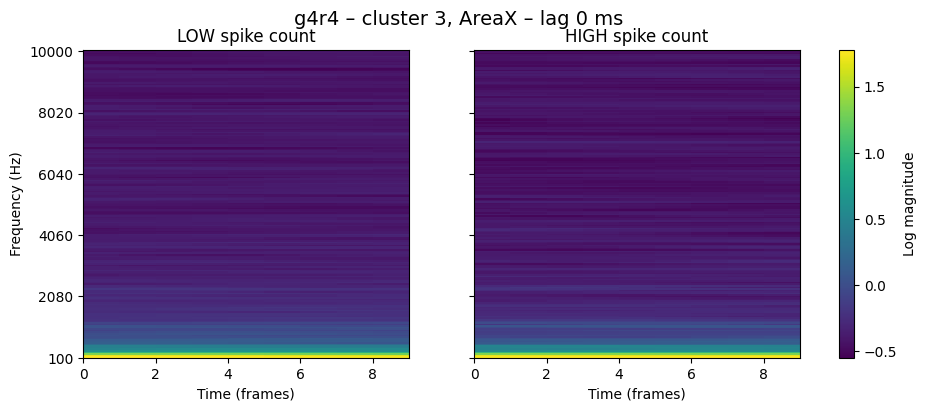

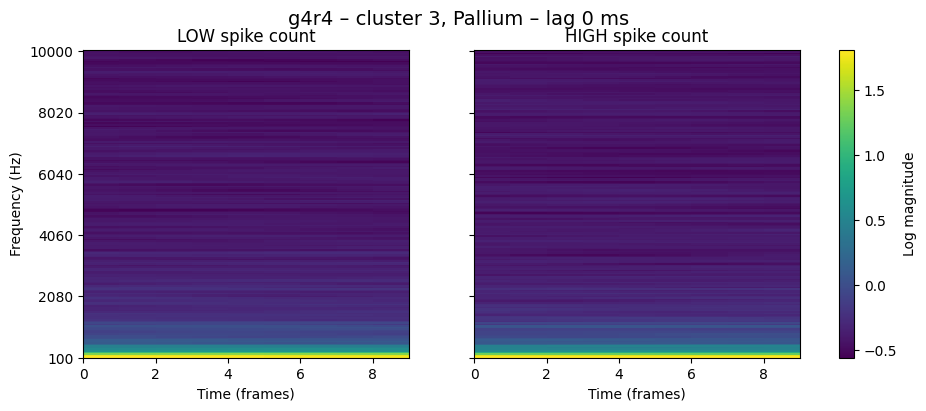

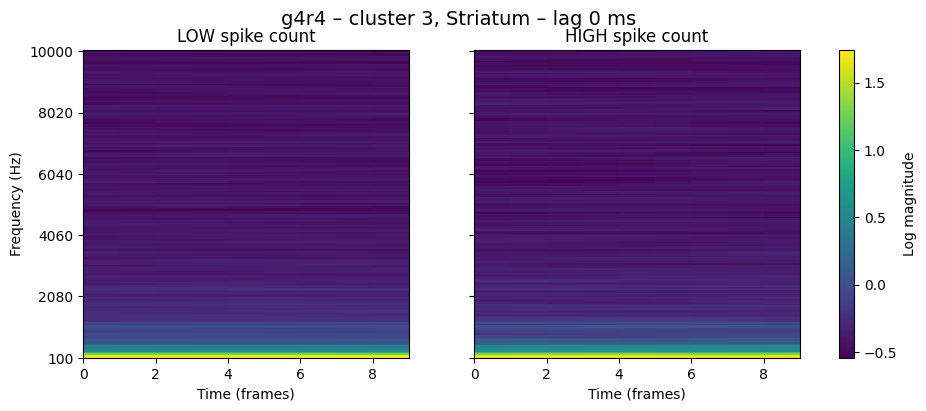

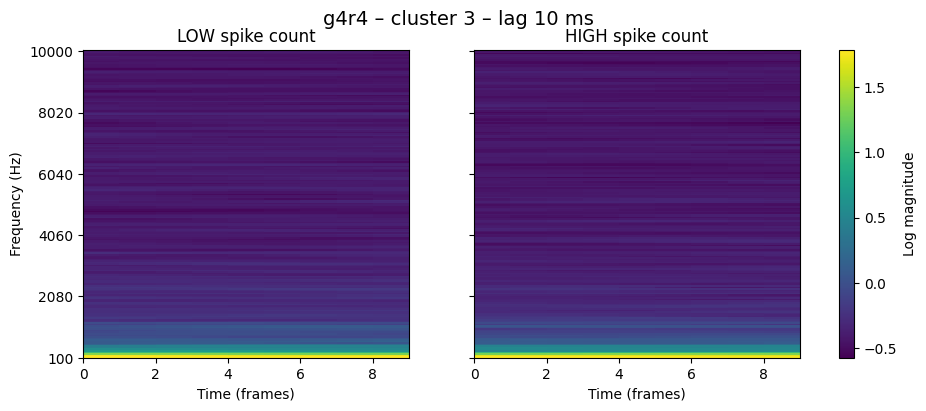

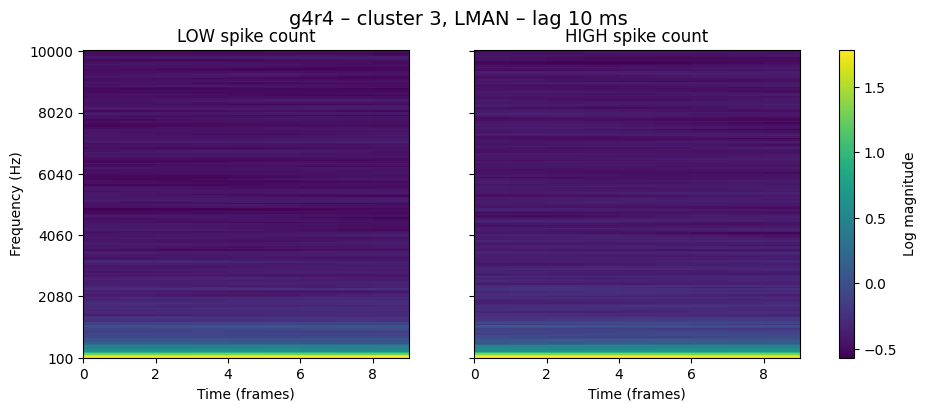

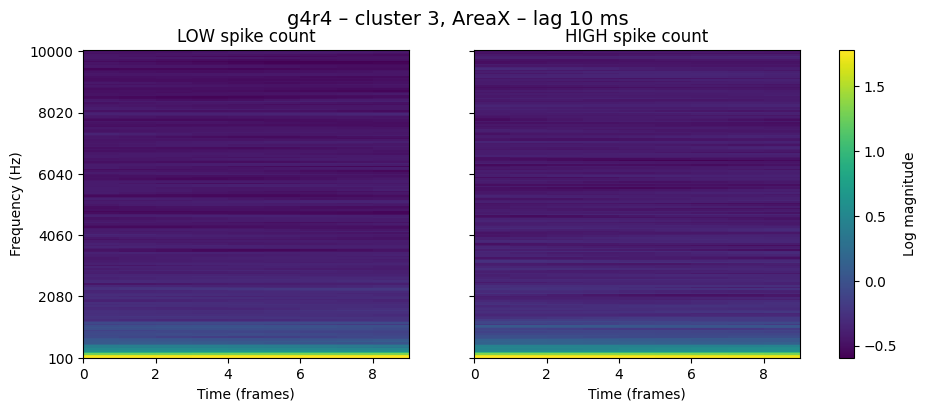

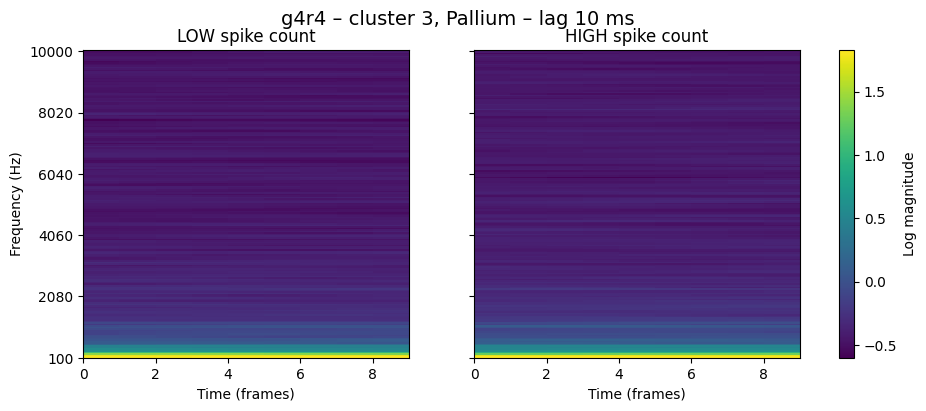

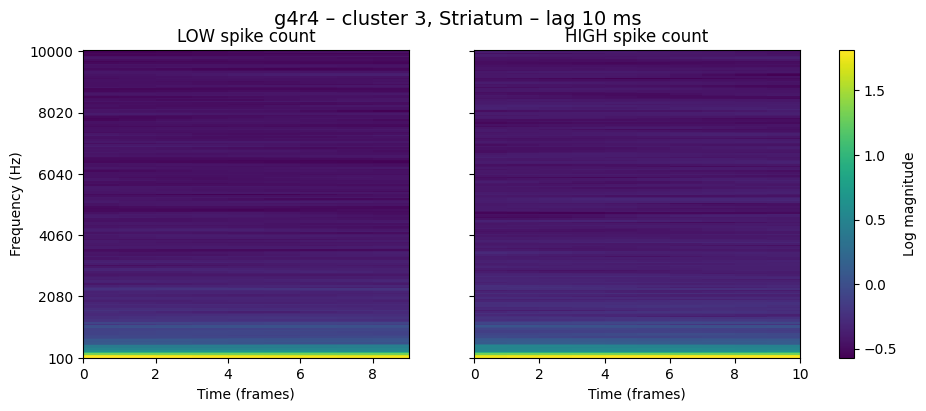

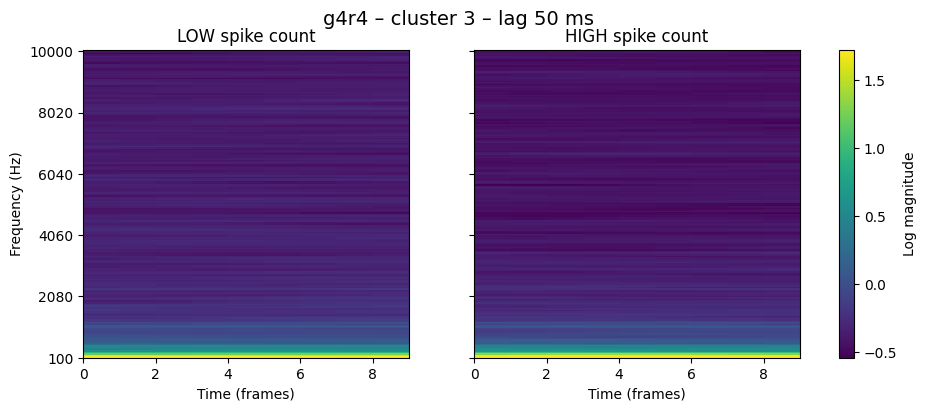

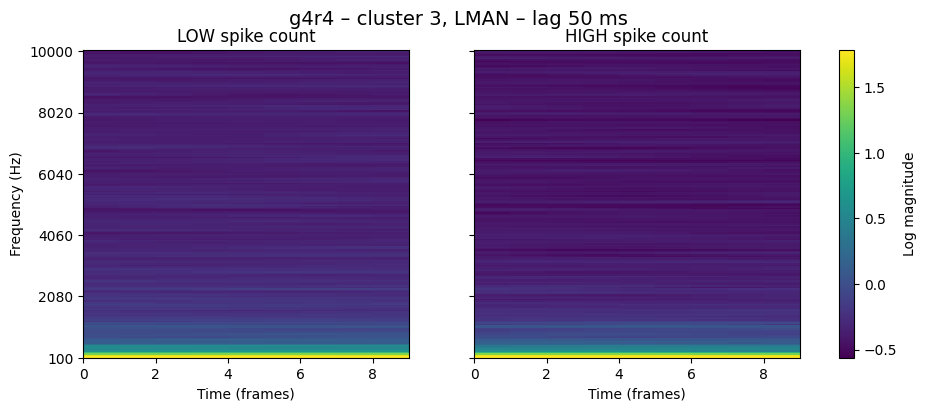

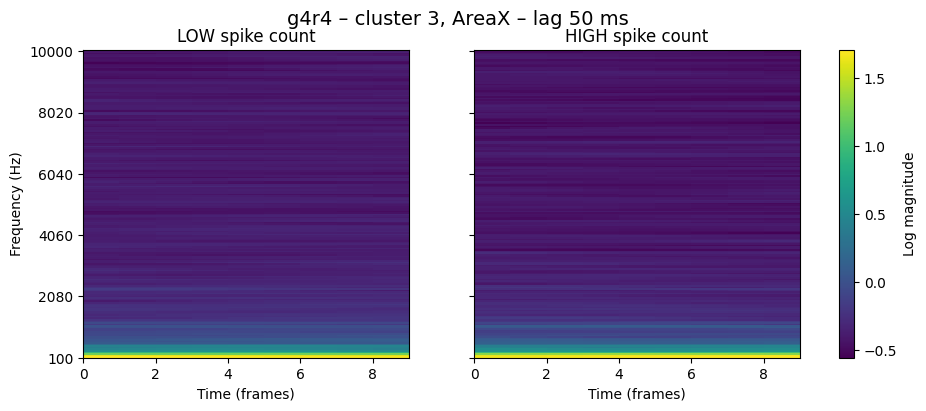

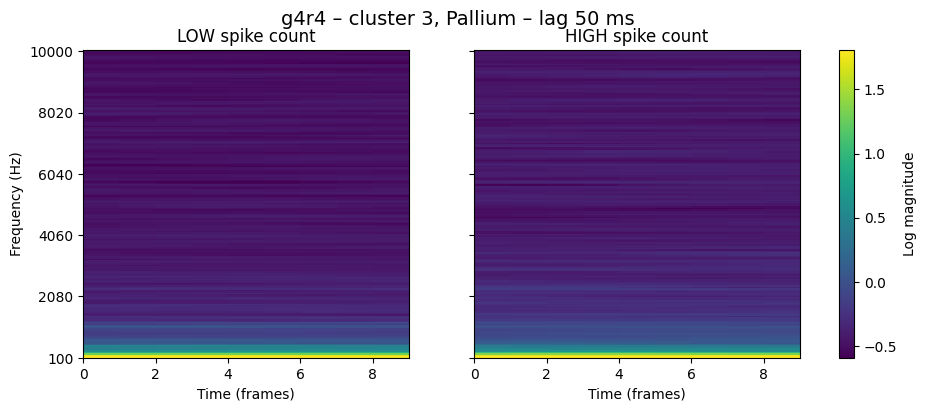

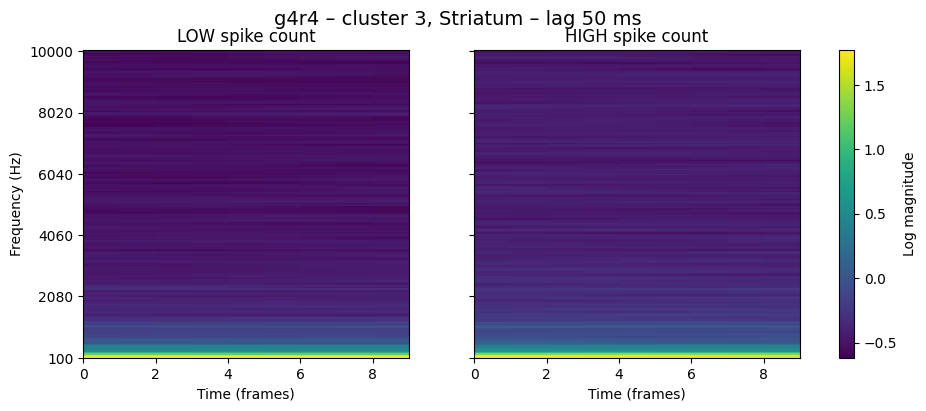

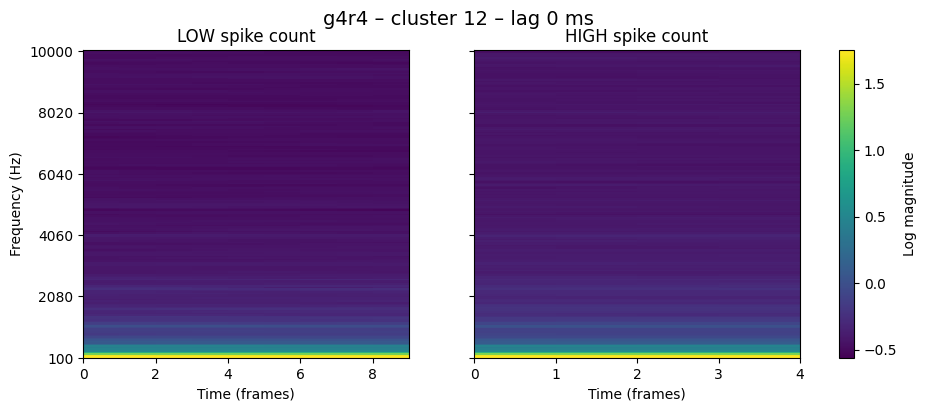

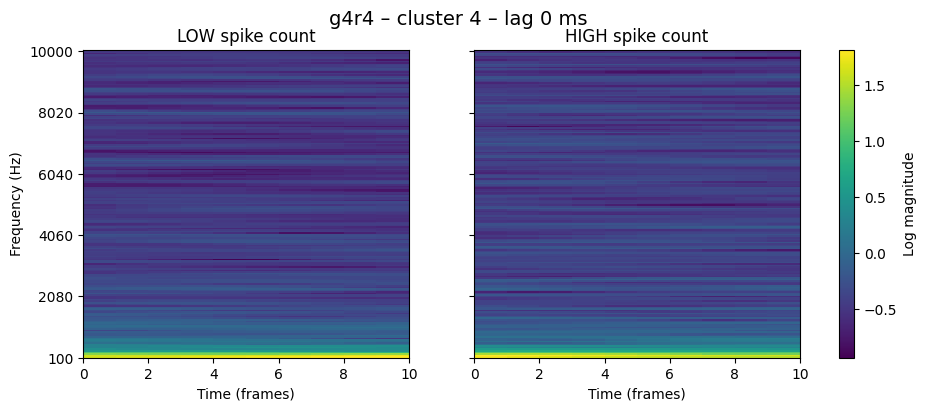

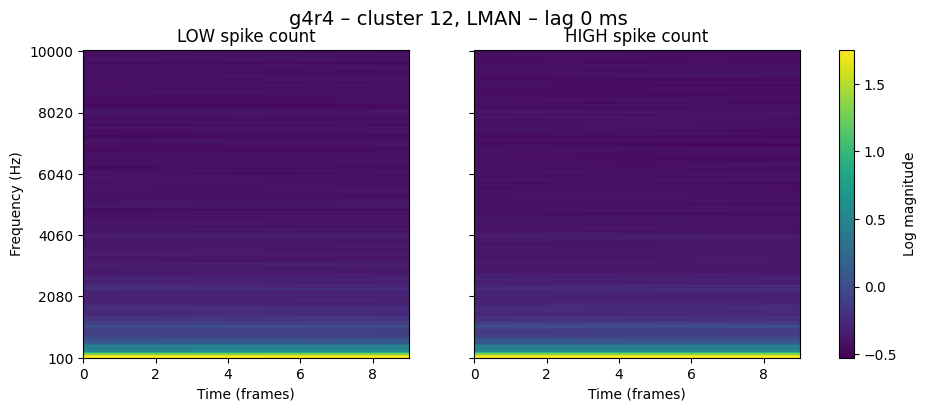

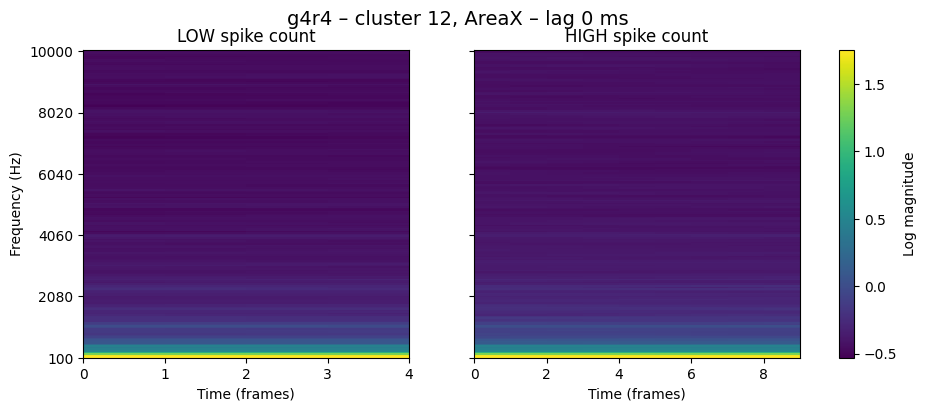

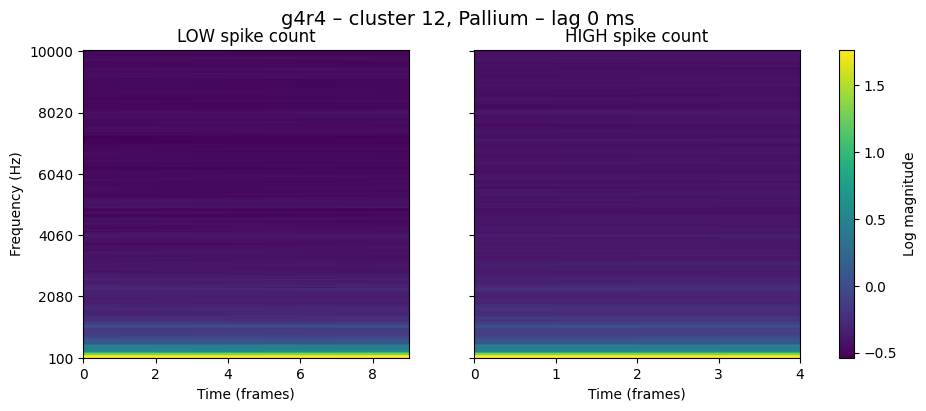

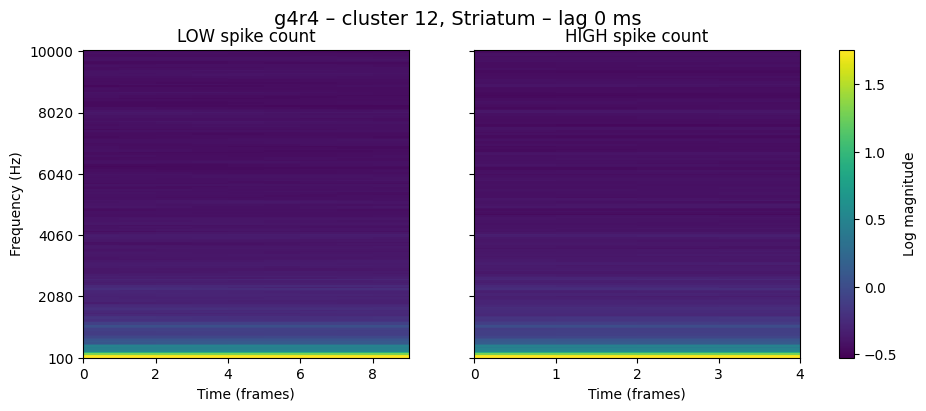

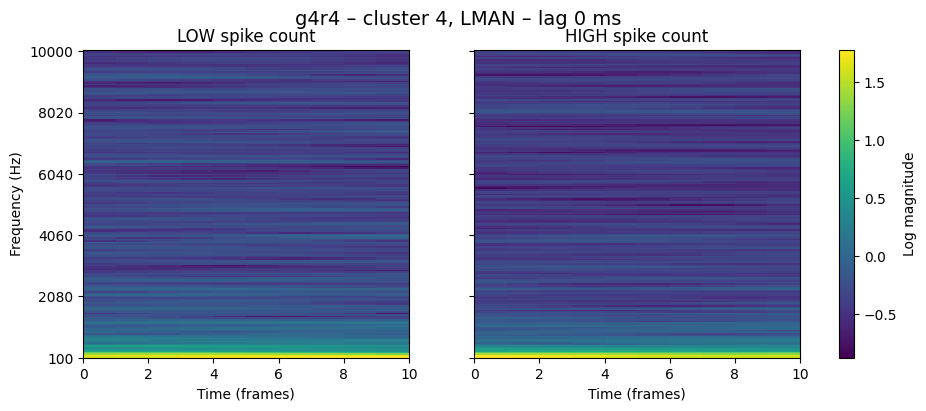

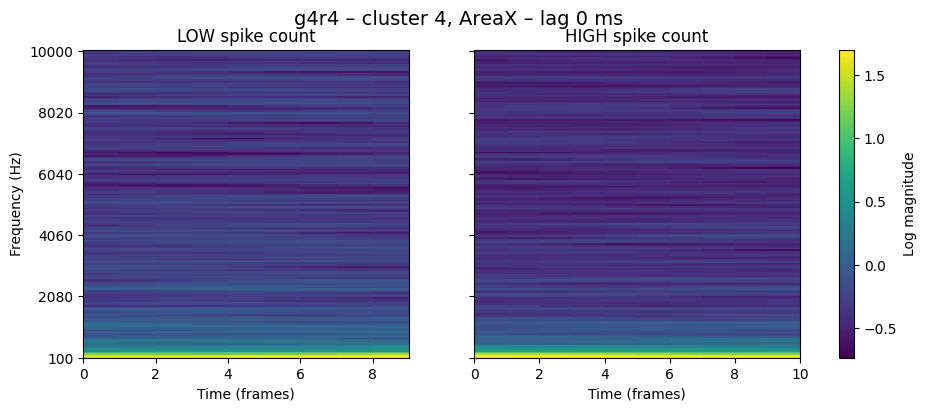

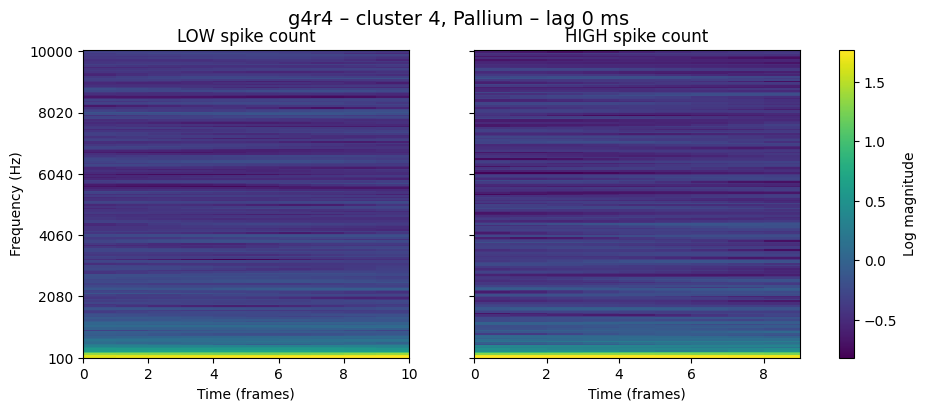

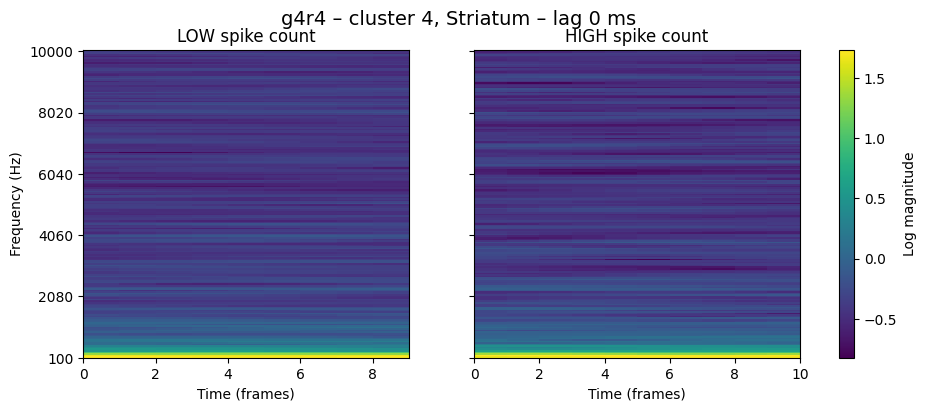

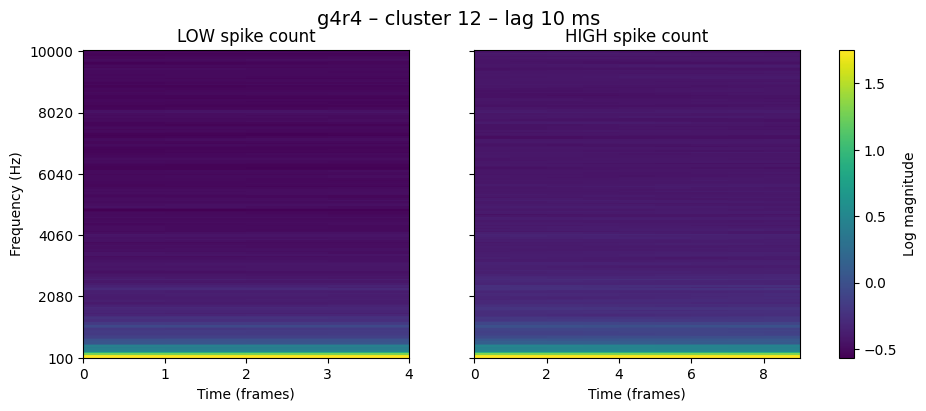

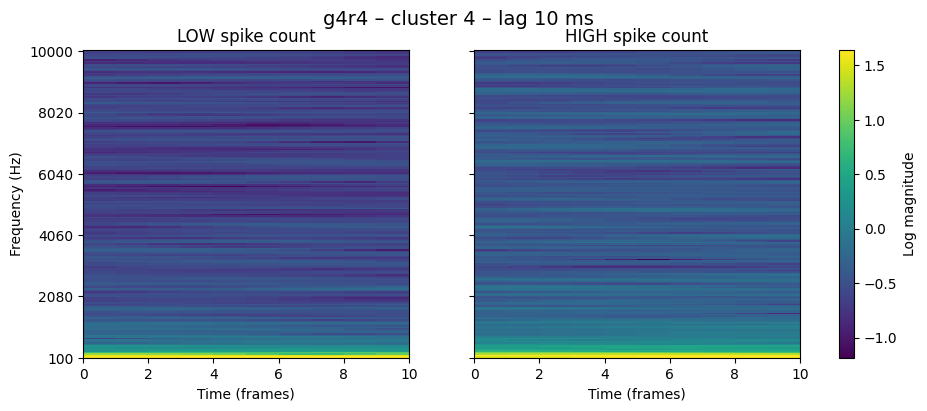

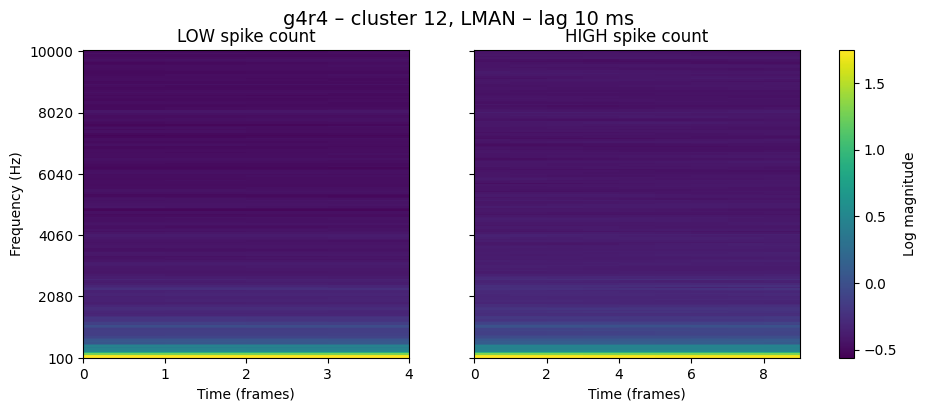

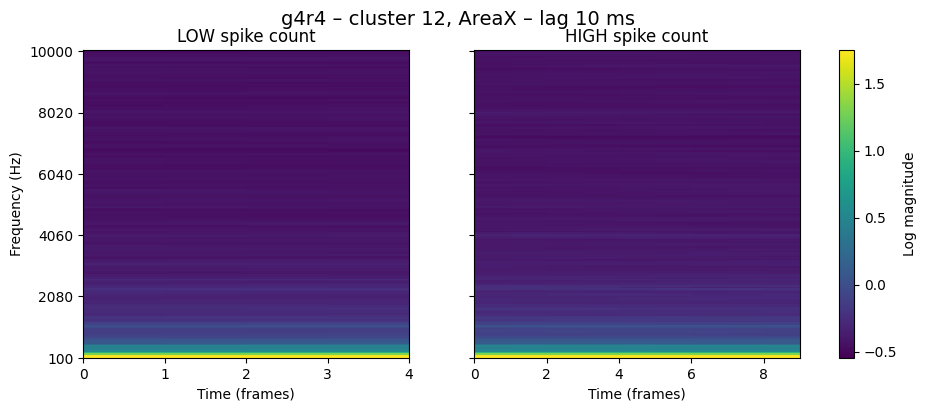

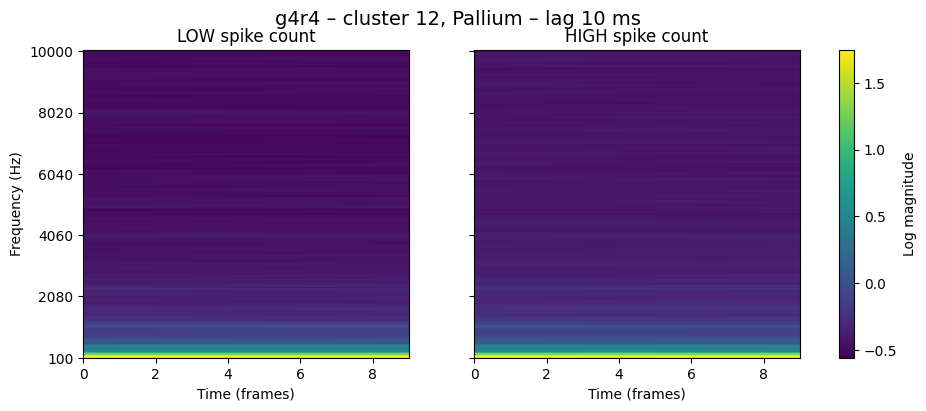

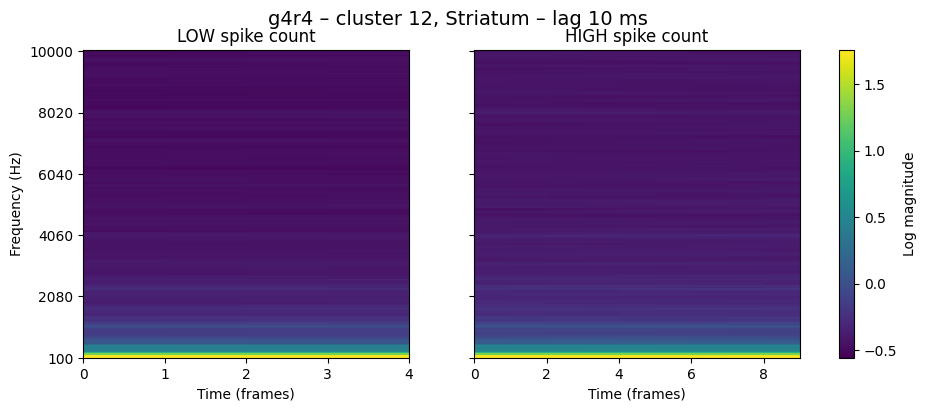

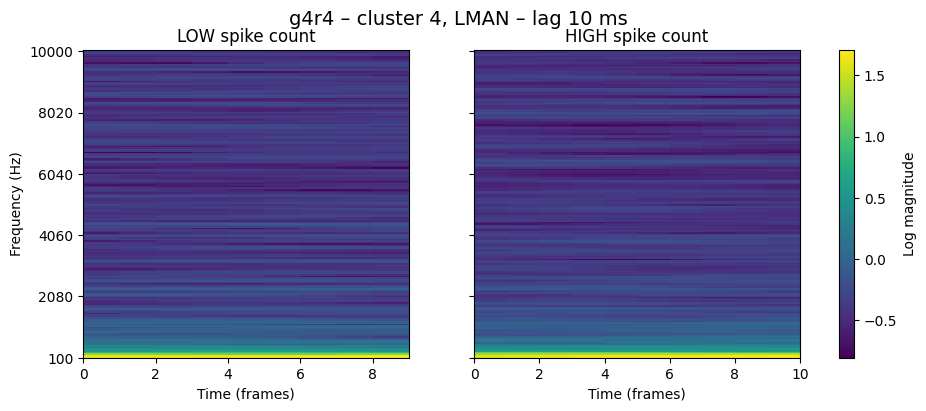

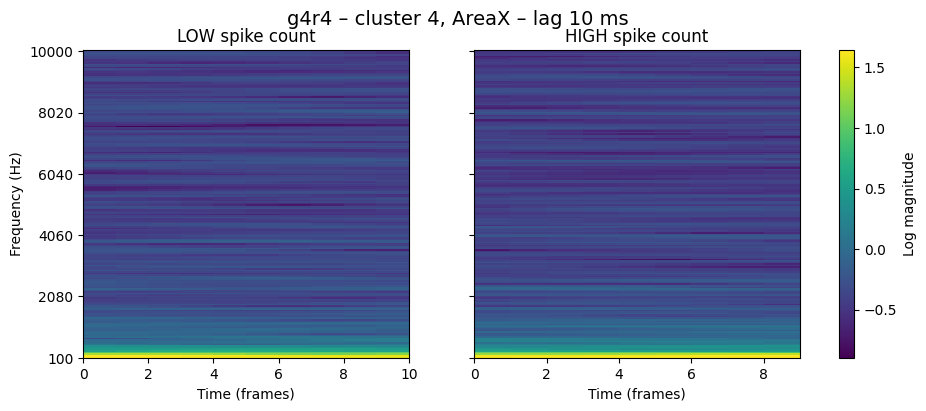

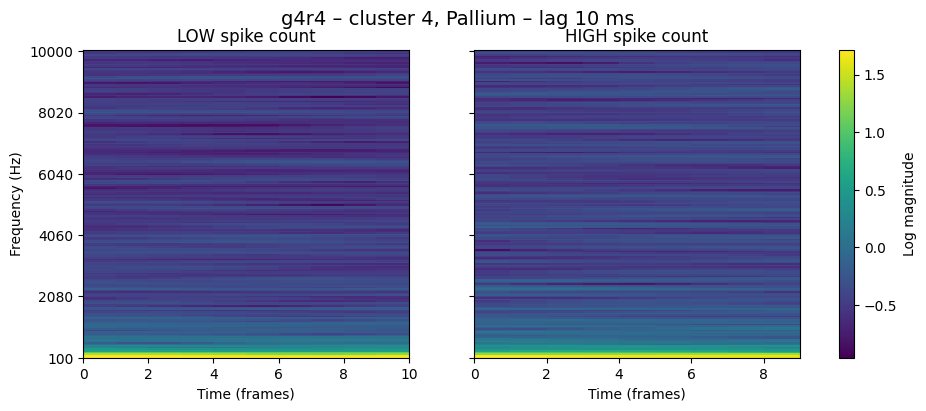

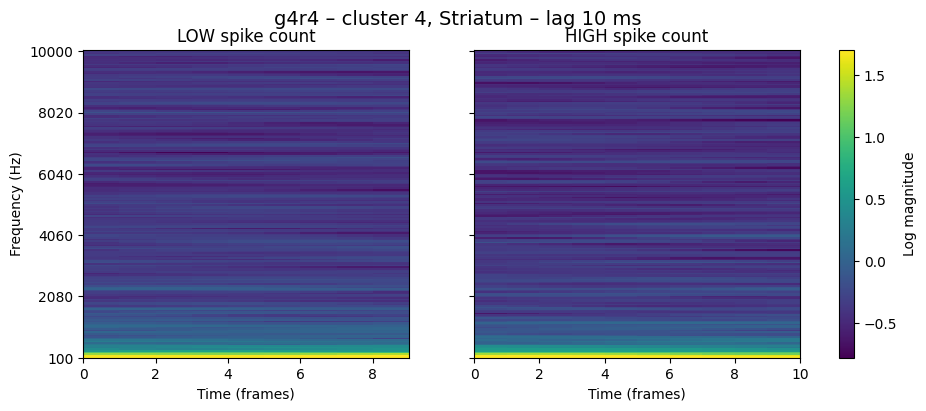

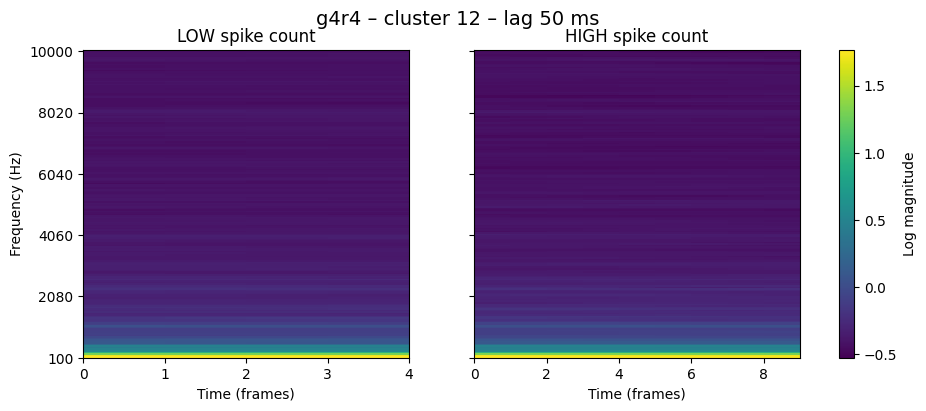

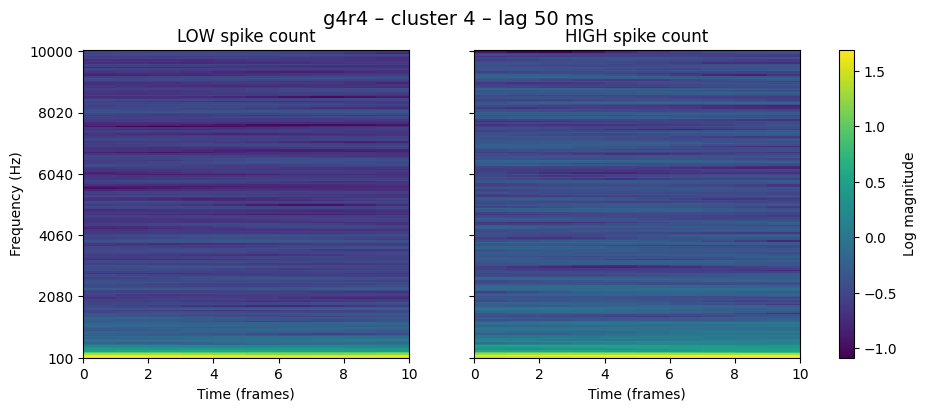

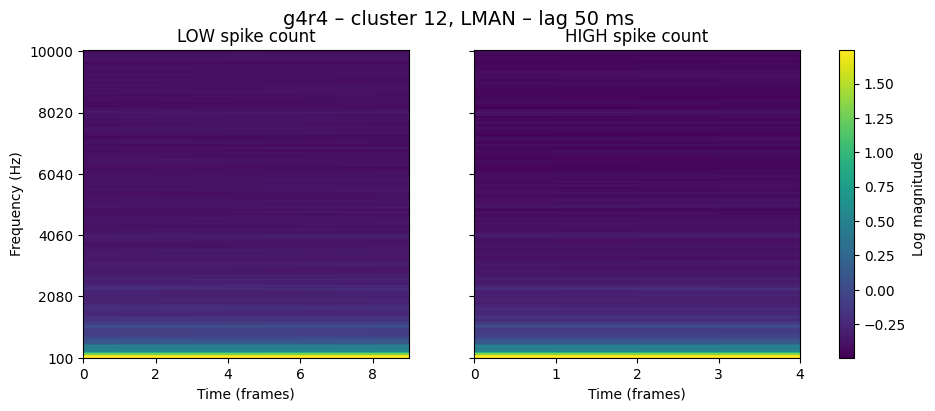

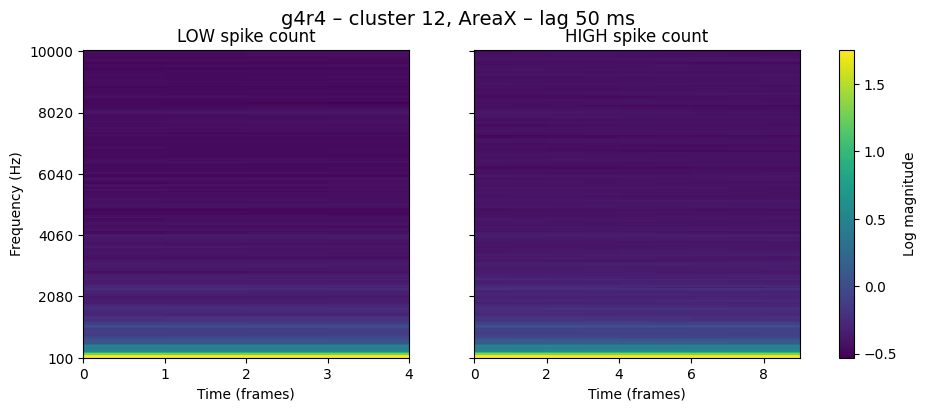

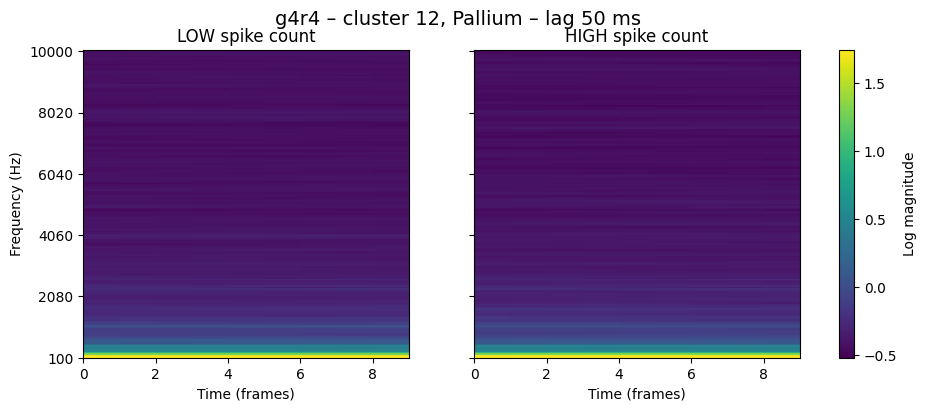

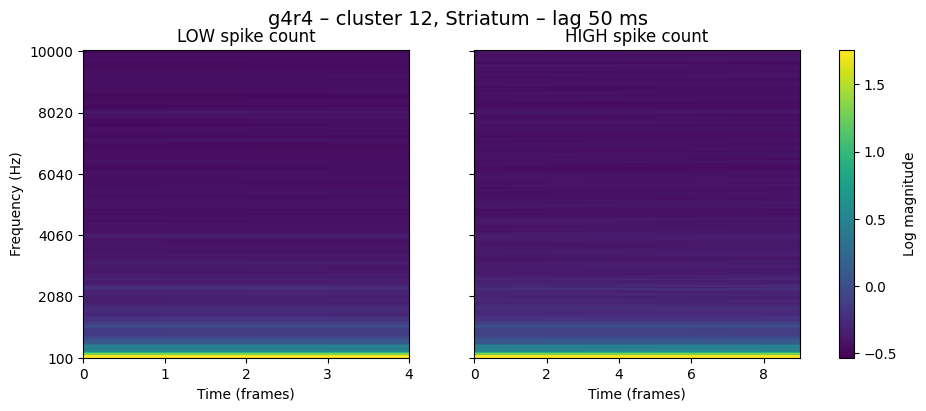

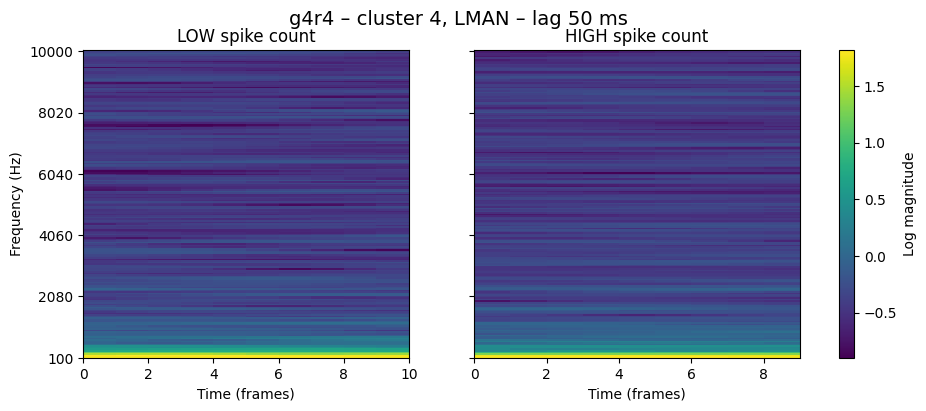

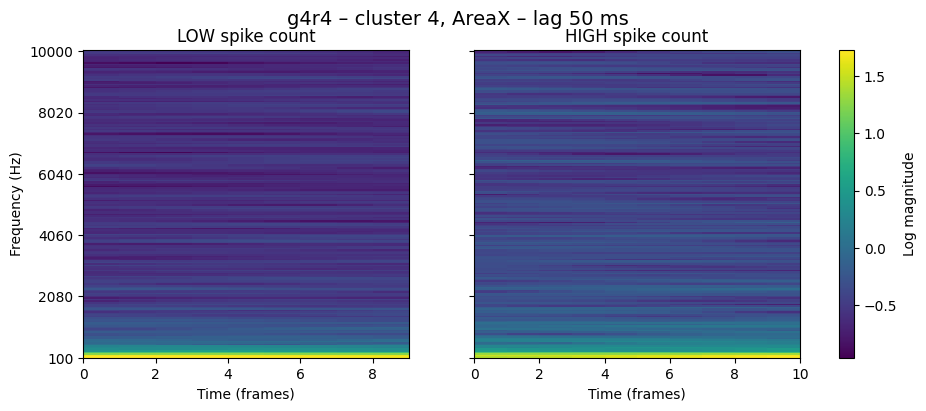

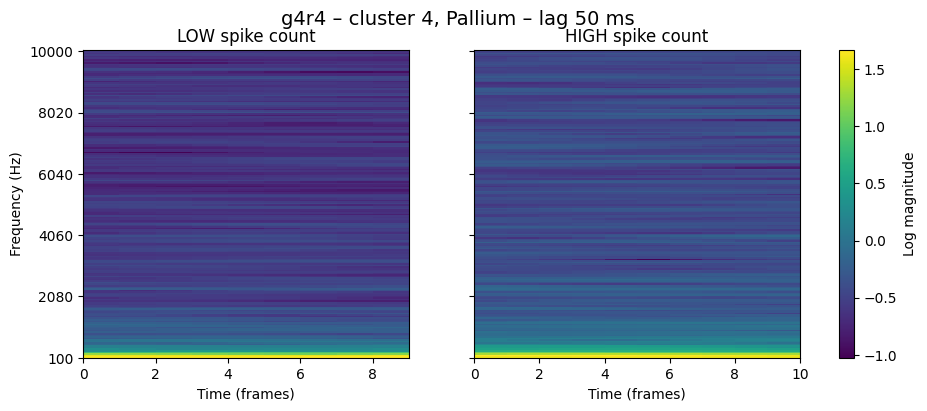

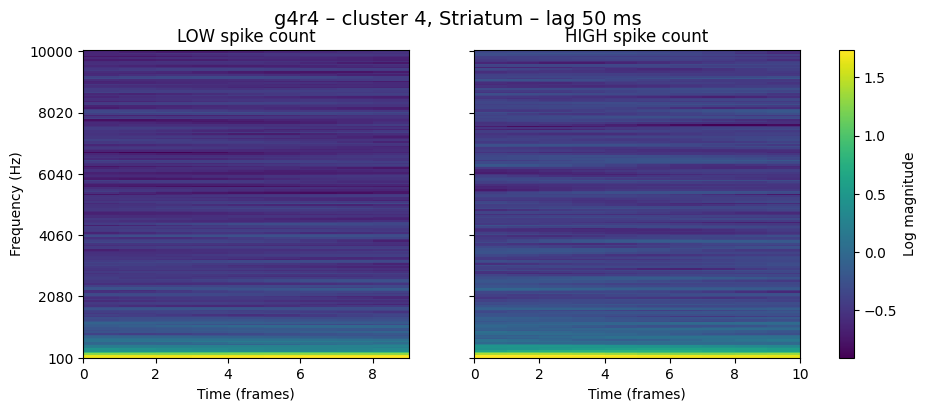

In [31]:
########################################
# ACTUAl EXECUTION
# Set parameters here
######################################## 

low_segments_by_bird, high_segments_by_bird = split_segments_high_low(segments_10ms, lags=[0, 4], want_cluster=True, want_region=True, want_cluster_region=True, want_population=True)

for key in low_segments_by_bird:
    bird = key[0]

    low_by_bird  = {bird: low_segments_by_bird.get(key, [])}
    high_by_bird = {bird: high_segments_by_bird.get(key, [])}

    avg_low, avg_high = average_stft_high_low(low_by_bird, high_by_bird)

    plot_avg_low_high_spectrograms(
        bird,
        avg_low,
        avg_high,
        reconstructed,
        group_key=key,
        log_scale=True
    )
